# imports

In [1]:
!pip install einops
!pip install zarr
!pip install xarray[io]
!pip install -Uqq ipdb
from numpy import save, load
from pathlib import Path
import dask.array as da
import warnings
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import ipdb
from tqdm import tqdm
import torch
from sklearn.metrics import f1_score, precision_score, accuracy_score, recall_score, roc_auc_score, average_precision_score
import numpy as np
from torch import nn
import math
from torch.optim.optimizer import Optimizer
import pandas as pd
from einops import rearrange
from torch.nn import functional as F
import xarray as xr
from torch.utils.data import Dataset, DataLoader
import zarr
import sys


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.9/206.9 kB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 82.3 MB/s eta 0:00:00
  Created wheel for asciitree: filename=asciitree-0.3.3-py3-none-any.whl size=5050 sha256=3d1906345c154f86c5aea4a544e5a0a2b684c00b1bc085284550102ca40160cb
  Stored in directory: /root/.cache/pip/wheels/7f/4e/be/1171b40f43b918087657ec57cf3b81fa1a2e027d8755baa184
Successfully built asciitree
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 3.1 MB/s eta 0:00:00


In [2]:
%pdb off

Automatic pdb calling has been turned OFF


# support classes for model

In [3]:
#from Models.AbsolutePositionalEncoding import tAPE, AbsolutePositionalEncoding, LearnablePositionalEncoding
#from Models.Attention import Attention, Attention_Rel_Scl, Attention_Rel_Vec

def get_optimizer(name):

    if name == "Adam":
        return torch.optim.Adam
    elif name == "RAdam":
        return RAdam

def get_loss_module():
    return NoFussCrossEntropyLoss(reduction='none')  # outputs loss for each batch sample
class WeightedBCELoss(nn.Module):
    def __init__(self, pos_weight):
        super(WeightedBCELoss, self).__init__()
        self.pos_weight = pos_weight

    def forward(self, inputs, targets):
        # Compute the weighted BCE loss
        loss = torch.nn.functional.binary_cross_entropy_with_logits(inputs, targets, pos_weight=self.pos_weight)
        return loss

class Permute(nn.Module):
    def forward(self, x):
        return x.permute(1, 0, 2)

# from https://github.com/LiyuanLucasLiu/RAdam/blob/master/radam/radam.py
class RAdam(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, degenerated_to_sgd=True):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))

        self.degenerated_to_sgd = degenerated_to_sgd
        if isinstance(params, (list, tuple)) and len(params) > 0 and isinstance(params[0], dict):
            for param in params:
                if 'betas' in param and (param['betas'][0] != betas[0] or param['betas'][1] != betas[1]):
                    param['buffer'] = [[None, None, None] for _ in range(10)]
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay,
                        buffer=[[None, None, None] for _ in range(10)])
        super(RAdam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(RAdam, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)

                state['step'] += 1
                buffered = group['buffer'][int(state['step'] % 10)]
                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2 ** state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma

                    # more conservative since it's an approximated value
                    if N_sma >= 5:
                        step_size = math.sqrt(
                            (1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (
                                        N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    elif self.degenerated_to_sgd:
                        step_size = 1.0 / (1 - beta1 ** state['step'])
                    else:
                        step_size = -1
                    buffered[2] = step_size

                # more conservative since it's an approximated value
                if N_sma >= 5:
                    if group['weight_decay'] != 0:
                        p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(exp_avg, denom, value=-step_size * group['lr'])
                    p.data.copy_(p_data_fp32)
                elif step_size > 0:
                    if group['weight_decay'] != 0:
                        p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)
                    p_data_fp32.add_(exp_avg, alpha=-step_size * group['lr'])
                    p.data.copy_(p_data_fp32)

        return loss

class tAPE(nn.Module):
    r"""Inject some information about the relative or absolute position of the tokens
        in the sequence. The positional encodings have the same dimension as
        the embeddings, so that the two can be summed. Here, we use sine and cosine
        functions of different frequencies.
    .. math::
        \text{PosEncoder}(pos, 2i) = sin(pos/10000^(2i/d_model))
        \text{PosEncoder}(pos, 2i+1) = cos(pos/10000^(2i/d_model))
        \text{where pos is the word position and i is the embed idx)
    Args:
        d_model: the embed dim (required).
        dropout: the dropout value (default=0.1).
        max_len: the max. length of the incoming sequence (default=1024).
    """

    def __init__(self, d_model, dropout=0.1, max_len=1024, scale_factor=1.0):
        super(tAPE, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)  # positional encoding
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin((position * div_term)*(d_model/max_len))
        pe[:, 1::2] = torch.cos((position * div_term)*(d_model/max_len))
        pe = scale_factor * pe.unsqueeze(0)
        self.register_buffer('pe', pe)  # this stores the variable in the state_dict (used for non-trainable variables)

    def forward(self, x):
        r"""Inputs of forward function
        Args:
            x: the sequence fed to the positional encoder model (required).
        Shape:
            x: [sequence length, batch size, embed dim]
            output: [sequence length, batch size, embed dim]
        """
        x = x + self.pe
        return self.dropout(x)

class Attention_Rel_Scl(nn.Module):
    def __init__(self, emb_size, num_heads, seq_len, dropout):
        super().__init__()
        self.seq_len = seq_len
        self.num_heads = num_heads
        self.scale = emb_size ** -0.5
        # self.to_qkv = nn.Linear(inp, inner_dim * 3, bias=False)
        self.key = nn.Linear(emb_size, emb_size, bias=False)
        self.value = nn.Linear(emb_size, emb_size, bias=False)
        self.query = nn.Linear(emb_size, emb_size, bias=False)

        self.relative_bias_table = nn.Parameter(torch.zeros((2 * self.seq_len - 1), num_heads))
        coords = torch.meshgrid((torch.arange(1), torch.arange(self.seq_len)))
        coords = torch.flatten(torch.stack(coords), 1)
        relative_coords = coords[:, :, None] - coords[:, None, :]
        relative_coords[1] += self.seq_len - 1
        relative_coords = rearrange(relative_coords, 'c h w -> h w c')
        relative_index = relative_coords.sum(-1).flatten().unsqueeze(1)
        self.register_buffer("relative_index", relative_index)

        self.dropout = nn.Dropout(dropout)
        self.to_out = nn.LayerNorm(emb_size)

    def forward(self, x):
        batch_size, seq_len, _ = x.shape
        k = self.key(x).reshape(batch_size, seq_len, self.num_heads, -1).permute(0, 2, 3, 1)
        v = self.value(x).reshape(batch_size, seq_len, self.num_heads, -1).transpose(1, 2)
        q = self.query(x).reshape(batch_size, seq_len, self.num_heads, -1).transpose(1, 2)
        # k,v,q shape = (batch_size, num_heads, seq_len, d_head)

        attn = torch.matmul(q, k) * self.scale
        # attn shape (seq_len, seq_len)
        attn = nn.functional.softmax(attn, dim=-1)

        # Use "gather" for more efficiency on GPUs
        relative_bias = self.relative_bias_table.gather(0, self.relative_index.repeat(1, 8))
        relative_bias = rearrange(relative_bias, '(h w) c -> 1 c h w', h=1 * self.seq_len, w=1 * self.seq_len)
        attn = attn + relative_bias

        # distance_pd = pd.DataFrame(relative_bias[0,0,:,:].cpu().detach().numpy())
        # distance_pd.to_csv('scalar_position_distance.csv')

        out = torch.matmul(attn, v)
        # out.shape = (batch_size, num_heads, seq_len, d_head)
        out = out.transpose(1, 2)
        # out.shape == (batch_size, seq_len, num_heads, d_head)
        out = out.reshape(batch_size, seq_len, -1)
        # out.shape == (batch_size, seq_len, d_model)
        out = self.to_out(out)
        return out

class NoFussCrossEntropyLoss(nn.CrossEntropyLoss):
    """
    pytorch's CrossEntropyLoss is fussy: 1) needs Long (int64) targets only, and 2) only 1D.
    This function satisfies these requirements
    """

    def forward(self, inp, target):
        return F.cross_entropy(inp, target.long(), weight=self.weight,
                               ignore_index=self.ignore_index, reduction=self.reduction)

# Temporal ConvTran Model

In [4]:

class TemporalConvTran(nn.Module):
    def __init__(self, config, num_classes): # config needs 'Data_shape', 'emb_size', 'num_heads', 'dim_ff'
        super().__init__()
        # Parameters Initialization -----------------------------------------------
        channel_size, seq_len = config['Data_shape'][1], config['Data_shape'][2]
        emb_size = config['emb_size']
        num_heads = config['num_heads']
        dim_ff = config['dim_ff']
        # Embedding Layer -----------------------------------------------------------
        # input data should have a shape of (batch_size, time, channel_size) each batch is the data from a grid point

        #input shape for conv2d is batch_size, input_channels, height, width. ignore input channels. it is already one
        #shape of their input is batch_size, feature_size, sequence_len
        self.input_normalization = nn.BatchNorm1d(channel_size, eps=1e-5, momentum=0.1, affine=True, track_running_stats=True)
        self.embed_layer = nn.Sequential(nn.Conv2d(1, emb_size*4, kernel_size=(1, 8), padding='same'),
                                         nn.BatchNorm2d(emb_size*4),
                                         nn.GELU())

        self.embed_layer2 = nn.Sequential(nn.Conv2d(emb_size*4, emb_size, kernel_size=[channel_size, 1], padding='valid'),
                                          nn.BatchNorm2d(emb_size),
                                          nn.GELU())

        self.Fix_Position = tAPE(emb_size, dropout=config['dropout'], max_len=seq_len)

        self.attention_layer = Attention_Rel_Scl(emb_size, num_heads, seq_len, config['dropout'])

        self.LayerNorm = nn.LayerNorm(emb_size, eps=1e-5)
        self.LayerNorm2 = nn.LayerNorm(emb_size, eps=1e-5)

        self.FeedForward = nn.Sequential(
            nn.Linear(emb_size, dim_ff),
            nn.ReLU(),
            nn.Dropout(config['dropout']),
            nn.Linear(dim_ff, emb_size),
            nn.Dropout(config['dropout']))

        self.gap = nn.AdaptiveAvgPool1d(1)
        self.flatten = nn.Flatten()
        self.out = nn.Linear(emb_size, num_classes)
        self.out_binary = nn.Sigmoid()



    def forward(self, x_):
        #shape of their input x is batch_size, feature_size, sequence_len
        if torch.isnan(x_).any().item():
            ipdb.set_trace(context = 5)
        x_ = x_.squeeze(0)
        #ipdb.set_trace()
        x = self.input_normalization(x_)
        if torch.isnan(x).any().item():
            ipdb.set_trace(context = 5)
        #ipdb.set_trace()
        x = x.unsqueeze(1) #now it is batch_size, 1, feature_size, sequence_len where the 1 is how many channels for the conv2d in first embed
        #ipdb.set_trace()
        x_src = self.embed_layer(x)
        #ipdb.set_trace()
        x_src = self.embed_layer2(x_src)
        if torch.isnan(x_src).any().item():
            ipdb.set_trace(context = 5)
        x_src = x_src.squeeze(2)
        #ipdb.set_trace()
        x_src = x_src.permute(0, 2, 1)
        #ipdb.set_trace()
        x_src_pos = self.Fix_Position(x_src)
        #ipdb.set_trace()
        att = x_src + self.attention_layer(x_src_pos)
        #ipdb.set_trace()
        att = self.LayerNorm(att)
        #ipdb.set_trace()
        out = att + self.FeedForward(att)
        #ipdb.set_trace()
        out = self.LayerNorm2(out)
        #ipdb.set_trace()
        out = out.permute(0, 2, 1)
        #ipdb.set_trace()
        out = self.gap(out)
        #ipdb.set_trace()
        out = self.flatten(out)
        #ipdb.set_trace()
        out = self.out(out)
        #ipdb.set_trace()
        out = self.out_binary(out)
        #print(torch.isnan(out).any().item())
        #ipdb.set_trace()
        if torch.isnan(out).any().item():
            ipdb.set_trace(context = 5)
        return out

# Mesogeos Models

In [5]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int = 256, dropout: float = 0.1, max_len: int = 64):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)


class TransformerNet(nn.Module):
    """
    Text classifier based on a pytorch TransformerEncoder.
    """

    def __init__(
            self,
            seq_len=64,
            input_dim=29,
            d_model=256,
            nhead=8,
            dim_feedforward=512,
            num_layers=4,
            dropout=0.1,
            activation="relu",
            classifier_dropout=0.1,
            channel_attention=True
    ):

        super().__init__()
        assert d_model % nhead == 0, "nheads must divide evenly into d_model"

        # self.emb = nn.Embedding(input_dim, d_model)
        self.channel_attention = channel_attention

        self.lin_time = nn.Linear(input_dim, d_model)
        self.lin_channel = nn.Linear(seq_len, d_model)

        self.pos_encoder = PositionalEncoding(
            d_model=d_model,
            dropout=dropout
        )

        encoder_layer_time = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
        )
        self.transformer_encoder_time = nn.TransformerEncoder(
            encoder_layer_time,
            num_layers=num_layers,
        )

        encoder_layer_channel = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
        )
        self.transformer_encoder_channel = nn.TransformerEncoder(
            encoder_layer_channel,
            num_layers=num_layers,
        )

        self.out_time = nn.Linear(d_model, d_model)
        self.out_channel = nn.Linear(d_model, d_model)

        self.lin = nn.Linear(d_model * 2, 2)

        if self.channel_attention:
            self.classifier = nn.Linear(d_model * 2, 1)
        else:
            self.classifier = nn.Linear(d_model, 1)
        self.out_sigmoid = nn.Sigmoid()
        
        self.d_model = d_model

    def resh(self, x, y):
        return x.unsqueeze(1).expand(y.size(0), -1)

    def forward(self, x_): #input is samples, variables, sequence
        x_ = x_.squeeze()
        x_ = x_.permute(2, 0, 1)
        x = torch.tanh(self.lin_time(x_)) #wants sequence length, batch size, # variables
        x = self.pos_encoder(x)
        x = self.transformer_encoder_time(x)
        x = x[0, :, :]

        if self.channel_attention:
            y = torch.transpose(x_, 0, 2)
            y = torch.tanh(self.lin_channel(y))
            y = self.transformer_encoder_channel(y)

            x = torch.tanh(self.out_time(x))
            y = torch.tanh(self.out_channel(y[0, :, :]))

            h = self.lin(torch.cat([x, y], dim=1))

            m = nn.Softmax(dim=1)
            g = m(h)

            g1 = g[:, 0]
            g2 = g[:, 1]

            x = torch.cat([self.resh(g1, x) * x, self.resh(g2, x) * y], dim=1)

        x = self.classifier(x)
        x = self.out_sigmoid(x)
        return x

# Dataset + Dataloader

In [6]:
class TemporalDatasetFromNumpy_basic(Dataset):
    def __init__(self, numpy_array, sequence_length, train_ratio, pin_memory):
        self.numpy_array = numpy_array #shape (40, 40, 918, 29), lat, lon, time, var
        self.sequence_length = sequence_length
        self.pin_memory = pin_memory
        
        self.lat_size, self.lon_size, self.time_size, self.num_variables = self.numpy_array.shape

        self.time_size -= (sequence_length) #num of timesteps with targets
        self.numpy_array = self.numpy_array[:self.time_size]
        # 40, 40, 854, 29
        # 0 to 39
        
        self.train_ratio = train_ratio
        
        self.pos_indices = np.column_stack(np.where(self.numpy_array[:,:,self.sequence_length:, -1] == 1)) 
        # shape (number_of_occurences) by (lat_indices, lon_indices, time_indices)
        self.neg_indices = np.column_stack(np.where(self.numpy_array[:,:,self.sequence_length:, -1] == 0))
            
        #ipdb.set_trace()
        self.total_indices = None
        
        if (self.train_ratio): # True -> training; False -> eval
            
            neg_to_pos_ratio = 2
            num_rows = len(self.pos_indices)*neg_to_pos_ratio
            random_rows = np.random.choice(self.neg_indices.shape[0], size=num_rows, replace=False)
            #ipdb.set_trace()
            neg_indices_subset = self.neg_indices[random_rows, :]
            #ipdb.set_trace()
            
            self.total_indices = np.concatenate((self.pos_indices, neg_indices_subset), axis=0)
            #self.total_indices = np.concatenate((self.pos_indices, self.neg_indices), axis=0)
            
        else:
            self.total_indices = np.concatenate((self.pos_indices, self.neg_indices), axis=0)
        
        np.random.shuffle(self.total_indices)
        #ipdb.set_trace()
            
    def __len__(self): # num_samples * num_timesteps
        return len(self.total_indices)

    def __getitem__(self, index): # np array shape (40, 40, 918, 29), lat, lon, time, var
        #total indices shape (num samples) by (lat_indices, lon_indices, time_indices)
        lat_index = self.total_indices[index, 0]
        lon_index = self.total_indices[index, 1]
        time_index = self.total_indices[index, 2]

        # ex timesteps 0 to 64: 65 timesteps in total, features takes 0 to 63, target is 64th timestep
        target_np = self.numpy_array[lat_index, lon_index, time_index+sequence_length, -1] # only last variable gwis_ba
        features_np = self.numpy_array[lat_index, lon_index, time_index:time_index+sequence_length, : ] # all variables
        # lat, lon, time, var
        
        
        return features_np.squeeze(), target_np.squeeze()

def temporal_dataloader_basic(numpy_array, sequence_length, batch_size, train_ratio=True, pin_memory=False, num_workers=0):
    temporal_dataset = TemporalDatasetFromNumpy(numpy_array, sequence_length, train_ratio, pin_memory)
    dataloader = DataLoader(temporal_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=False)
    return dataloader


class TemporalDatasetFromNumpy(Dataset):
    def __init__(self, numpy_array, sequence_length, radius, pin_memory, train_or_test):
        self.numpy_array = numpy_array #shape (40, 40, 918, 29), lat, lon, time, var
        self.sequence_length = sequence_length
        self.pin_memory = pin_memory
        
        self.lat_size, self.lon_size, self.time_size, self.num_variables = self.numpy_array.shape

        self.time_size -= (sequence_length) #num of timesteps with targets
        self.numpy_array = self.numpy_array[:self.time_size]
        # 40, 40, 854, 29
        
        
        self.train_or_test = train_or_test
        
        self.pos_indices = np.column_stack(np.where(self.numpy_array[:,:,self.sequence_length:, -1] == 1)) 
        # shape (number_of_occurences) by (lat_indices, lon_indices, time_indices)
        self.neg_indices = np.column_stack(np.where(self.numpy_array[:,:,self.sequence_length:, -1] == 0))
            
        #ipdb.set_trace()
        self.total_indices = None
        
        if (self.train_or_test): # True -> training; False -> eval
             # 3/4 neg, 1/4 pos
            total_row_values_to_delete = None
            for index_arr in tqdm(self.pos_indices, desc = 'sampling'):
                lat = index_arr[0]
                lon = index_arr[1]
                time = index_arr[2]
                #radius = 0
                lat_range = np.arange(lat-radius, lat+radius+1) #lat is 5: np.arange(3,8) 3, 4, 5, 6, 7
                lon_range = np.arange(lon-radius, lon+radius+1)
                diameter = radius*2+1
                time_arr = np.array([time])

                grid1, grid2, grid3 = np.meshgrid(lat_range, lon_range, time_arr, indexing='ij')
                row_values_to_delete = np.vstack([grid1.ravel(), grid2.ravel(), grid3.ravel()]).T
                if total_row_values_to_delete is None:
                    total_row_values_to_delete = row_values_to_delete
                else:
                    total_row_values_to_delete = np.concatenate((total_row_values_to_delete, row_values_to_delete), axis=0)
                
            neg_indices_pd = pd.DataFrame(self.neg_indices)
            
            total_rows_to_delete_pd = pd.DataFrame(total_row_values_to_delete)
            n_index = neg_indices_pd.set_index([0,1,2]).index
            t_index = total_rows_to_delete_pd.set_index([0,1,2]).index
            mask = ~n_index.isin(t_index)
            result = neg_indices_pd.loc[mask]
            self.neg_indices = result.to_numpy()
            
            neg_to_pos_ratio = 2
            num_rows = len(self.pos_indices)*neg_to_pos_ratio
            random_rows = np.random.choice(self.neg_indices.shape[0], size=num_rows, replace=False)
            #ipdb.set_trace()
            neg_indices_subset = self.neg_indices[random_rows, :]
            #ipdb.set_trace()
            
            self.total_indices = np.concatenate((self.pos_indices, neg_indices_subset), axis=0)
            #self.total_indices = np.concatenate((self.pos_indices, self.neg_indices), axis=0)
            
        else:
            self.total_indices = np.concatenate((self.pos_indices, self.neg_indices), axis=0)
        
        np.random.shuffle(self.total_indices)
        #ipdb.set_trace()
            
    def __len__(self): # num_samples * num_timesteps
        return len(self.total_indices)

    def __getitem__(self, index): # np array shape (40, 40, 918, 29), lat, lon, time, var
        #total indices shape (num samples) by (lat_indices, lon_indices, time_indices)
        lat_index = self.total_indices[index, 0]
        lon_index = self.total_indices[index, 1]
        time_index = self.total_indices[index, 2]

        # ex timesteps 0 to 64: 65 timesteps in total, features takes 0 to 63, target is 64th timestep
        target_np = self.numpy_array[lat_index, lon_index, time_index+sequence_length, -1] # only last variable gwis_ba
        features_np = self.numpy_array[lat_index, lon_index, time_index:time_index+sequence_length, : ] # all variables
        # lat, lon, time, var
        
        #target_np shape ()
        #features_np shape (64,29) time, features
        #ipdb.set_trace()
        if self.pin_memory:
            target_tensor = torch.from_numpy(np.asarray(target_np)).pin_memory()
            features_tensor = torch.from_numpy(np.asarray(features_np)).pin_memory()
        else:
            target_tensor = torch.from_numpy(np.asarray(target_np))
            features_tensor = torch.from_numpy(np.asarray(features_np))
        target_tensor = target_tensor.float()
        features_tensor = features_tensor.float().permute(1,0) #now features, time
        
        #if (torch.isnan(features_tensor).any().item()):
        #    ipdb.set_trace(context=5)
        #if (torch.isnan(features_tensor).any().item()):
        #    return
        
        return features_tensor, target_tensor

def temporal_dataloader(numpy_array, sequence_length, batch_size, radius, train_or_test, pin_memory=True, num_workers=0):
    temporal_dataset = TemporalDatasetFromNumpy(numpy_array, sequence_length, radius, pin_memory, train_or_test)
    dataloader = DataLoader(temporal_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    return dataloader


# Trainer + Evaluator

In [7]:
# Define the training loop
def train(model, dataloader, optimizer, criterion, device, epoch_num): #each dataloader gives 1203*150 samples
    model.train()
    total_loss = 0.0
    total_samples = 0.0

    for batch_features, batch_target in tqdm(dataloader, desc = f'training epoch {epoch_num}'): #ndvi missing values
        if torch.isnan(batch_features).any().item():
            #Flatten:
            shape = batch_features.shape
            batch_features_reshaped = batch_features.reshape(shape[0],-1)
            #Drop all rows containing any nan:
            mask = ~torch.any(batch_features_reshaped.isnan(),dim=1)
            batch_features_reshaped = batch_features_reshaped[mask]
            #Reshape back:
            #ipdb.set_trace()
            batch_features = batch_features_reshaped.reshape(batch_features_reshaped.shape[0],*shape[1:])
            batch_target = batch_target[mask]

        batch_features = batch_features.to(device)
        batch_target = batch_target.squeeze().to(device)
        #ipdb.set_trace()
        # Forward pass
        outputs = model(batch_features).squeeze()
        #print(outputs, batch_target)

        if (torch.isnan(outputs).any().item()):
            ipdb.set_trace(context=5)

        loss = criterion(outputs, batch_target)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=4.0)
        optimizer.step()
        
        num_samples = len(outputs)
        total_loss+=loss.sum()
        total_samples += num_samples
        
        #print(f'batch #{num_batches} end')
    # retrieve: model.load_state_dict(torch.load(checkpoint_path))
    return total_loss, total_samples


def evaluate_model(model, dataloader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    total_f1 = 0.0
    total_recall = 0.0
    total_precision = 0.0
    total_accuracy = 0.0
    total_aucroc = 0.0
    total_auprc = 0.0
    total_loss = 0.0
    total_loss_samples = 0.0
    total_samples = 0.0 #because each batch is the same size

    for inputs, targets in tqdm(dataloader, desc = 'evaluating'):
        with torch.no_grad():
            #ipdb.set_trace(context=5)

            inputs = inputs.to(device)
            targets = targets.to(device)
            
            if torch.isnan(inputs).any().item():
                #Flatten:
                shape = inputs.shape
                inputs_reshaped = inputs.reshape(shape[0],-1)
                #Drop all rows containing any nan:
                mask = ~torch.any(inputs_reshaped.isnan(),dim=1)
                inputs_reshaped = inputs_reshaped[mask]
                #Reshape back:
                #ipdb.set_trace()
                inputs = inputs_reshaped.reshape(inputs_reshaped.shape[0],*shape[1:])
                targets = targets[mask]
            
            #ipdb.set_trace(context=5)
            # Forward pass
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, targets)
            
            #ipdb.set_trace(context=5)
            targets = targets.squeeze().cpu().numpy()
            predicted = torch.round(outputs).cpu().numpy()

            num_samples = len(targets)
            
            
            total_loss+=loss.sum()
            total_loss_samples += num_samples
            
            #ipdb.set_trace(context=5)
            #true, pred
            if (np.sum(targets) > 0):
                #ipdb.set_trace()
                total_f1 += f1_score(targets, predicted, pos_label=1) * num_samples
                total_precision += precision_score(targets, predicted, pos_label=1) * num_samples
                total_accuracy += accuracy_score(targets, predicted) * num_samples
                total_recall += recall_score(targets, predicted, pos_label=1) * num_samples
                total_aucroc += roc_auc_score(targets, predicted) * num_samples
                total_auprc += average_precision_score(targets, predicted) * num_samples
                total_samples += num_samples

    #average_f1 = total_f1 / total_batches
    #average_recall = total_recall / total_batches
    #average_precision = total_precision / total_batches
    #average_aucroc = total_aucroc / total_batches
    #average_accuracy = total_accuracy / total_batches
    return total_f1, total_recall, total_precision, total_auprc, total_aucroc, total_accuracy, total_samples, total_loss, total_loss_samples

# configging

In [8]:
feature_names = ['tp', 'rel_hum', 'ws10', 't2m_mean', 't2m_min', 't2m_max', 'swvl1', 'swvl2', 'swvl3', 'swvl4', 'lsm', 'drought_code_max',
                 'drought_code_mean', 'fwi_max', 'fwi_mean', 'lst_day', 'lai', 'ndvi', 'pop_dens', 'lccs_class_0', 'lccs_class_1',
                 'lccs_class_2', 'lccs_class_3', 'lccs_class_4', 'lccs_class_5', 'lccs_class_6', 'lccs_class_7', 'lccs_class_8', 'gwis_ba']
target_name = ['gwis_ba']
sequence_length = 64 # look back 512 days
config = {
    'emb_size' : 16,
    'dim_ff' : 256,
    'num_heads' : 8,
    'lr' : 1e-5,
    'dropout' : 0.01,
    'seed' : 1234,
    'Data_shape' : [4000, len(feature_names), sequence_length], #samples, features, time
    'num_labels' : 1
}

# config needs 'Data_shape', 'emb_size', 'num_heads', 'dim_ff'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#num_epochs = 20


# RUN!!!

conv tran

In [9]:
ConvTranModel = TemporalConvTran(config, num_classes=config['num_labels'])
optimizer = RAdam(ConvTranModel.parameters(), lr=config['lr'], weight_decay=0)
#pos_weight = torch.tensor([0.5]).to(device)
#criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
criterion = nn.CrossEntropyLoss()
#criterion = get_loss_module()
print(sum(p.numel() for p in ConvTranModel.parameters()))

ConvTranModel.to(device)

num_epochs = 50
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    
    batch_size = 50
    file_path = Path('/kaggle/input/california-spatial-temporal-fire-dataset/numpy_california_spatialtemporal_dataset.npy')
    train_numpy_array = np.load(file_path)[:,:,:700,:]
    train_dataloader = temporal_dataloader(train_numpy_array, sequence_length, batch_size, radius = 0, train_or_test = True, pin_memory = False, num_workers=0)
    loss, samples = train(ConvTranModel, train_dataloader, optimizer, criterion, device, epoch)
    del train_numpy_array
    del train_dataloader
    #checkpoint_path = f'/kaggle/output/model_checkpoints/model_checkpoint_epoch_{epoch}.pt'
    #torch.save(ConvTranModel.state_dict(), checkpoint_path)
    train_losses.append(loss.item()/samples)
    
    batch_size = 50
    val_numpy_array = np.load(file_path)[:,:,700:,:]
    val_dataloader = temporal_dataloader(val_numpy_array, sequence_length, batch_size, radius = 0, train_or_test = True, pin_memory = False, num_workers=0)
    f1, recall, precision, auprc, aucroc, accuracy, samples, loss, loss_samples = evaluate_model(ConvTranModel, val_dataloader, criterion, device)
    del val_numpy_array
    del val_dataloader
    
    val_losses.append(loss.item()/loss_samples)
    
    print(f'epoch #{epoch}:')
    print(f'train_loss: {train_losses[epoch]}; val_loss: {val_losses[epoch]}!')
    print(f'f1: {f1/samples}')
    print(f'recall: {recall/samples}')
    print(f'precision: {precision/samples}')
    print(f'auprc: {auprc/samples}')
    print(f'aucroc: {aucroc/samples}')
    print(f'accuracy: {accuracy/samples}')

/opt/conda/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


40867


training epoch 0:   0%|          | 0/386 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/conv.py:459: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/Convolution.cpp:1003.)
  return F.conv2d(input, weight, bias, self.stride,
evaluating: 100%|██████████| 124/124 [00:01<00:00, 83.11it/s]


epoch #0:
train_loss: 1.299735710214023; val_loss: 1.2909269617380026!
f1: 0.513971563799341
recall: 0.9727355923623767
precision: 0.35361359936710846
auprc: 0.35344370185203183
aucroc: 0.5415415553536437
accuracy: 0.3976977950713359


evaluating: 100%|██████████| 124/124 [00:01<00:00, 84.02it/s]


epoch #1:
train_loss: 1.2890192749365088; val_loss: 1.2817797106941515!
f1: 0.5819076849025244
recall: 0.8752430670828203
precision: 0.44047870048483334
auprc: 0.42957170129748584
aucroc: 0.6602585688213981
accuracy: 0.5893900064892926


evaluating: 100%|██████████| 124/124 [00:01<00:00, 84.38it/s]


epoch #2:
train_loss: 1.278127712392476; val_loss: 1.2733978325918194!
f1: 0.592820406128297
recall: 0.8065595084234192
precision: 0.47549529806351915
auprc: 0.450241114491268
aucroc: 0.6806640512736258
accuracy: 0.6390465380249716


evaluating: 100%|██████████| 124/124 [00:01<00:00, 84.37it/s]


epoch #3:
train_loss: 1.268900386778273; val_loss: 1.2669017509727627!
f1: 0.5983428453956102
recall: 0.7691046559068339
precision: 0.49777187210878804
auprc: 0.46271566266934344
aucroc: 0.6896432295640739
accuracy: 0.6618028534370947


evaluating: 100%|██████████| 124/124 [00:01<00:00, 81.26it/s]


epoch #4:
train_loss: 1.2617840295950358; val_loss: 1.2628550906032106!
f1: 0.6159338365962206
recall: 0.7457247112868968
precision: 0.5342629918252765
auprc: 0.48661816333073304
aucroc: 0.7102911007761415
accuracy: 0.698232527971461


evaluating: 100%|██████████| 124/124 [00:01<00:00, 79.19it/s]


epoch #5:
train_loss: 1.2548581175834284; val_loss: 1.2539770337583103!
f1: 0.6406384283944773
recall: 0.7050215382032569
precision: 0.5964894803247995
auprc: 0.5226027469848078
aucroc: 0.7343247444264142
accuracy: 0.7444462461488568


evaluating: 100%|██████████| 124/124 [00:01<00:00, 86.23it/s]


epoch #6:
train_loss: 1.2473704312723457; val_loss: 1.2509314964770883!
f1: 0.6247437280629845
recall: 0.6757112534158024
precision: 0.595772896696666
auprc: 0.5159283156732394
aucroc: 0.7238662333787498
accuracy: 0.7390105433901054


evaluating: 100%|██████████| 124/124 [00:01<00:00, 82.58it/s]


epoch #7:
train_loss: 1.2414883867039743; val_loss: 1.2455994523143645!
f1: 0.6390065359254179
recall: 0.6836166449680382
precision: 0.6106640788729083
auprc: 0.5277794903507531
aucroc: 0.7331057787216625
accuracy: 0.7501621271076524


evaluating: 100%|██████████| 124/124 [00:01<00:00, 84.98it/s]


epoch #8:
train_loss: 1.2394929446193512; val_loss: 1.245235635489298!
f1: 0.6385978372994784
recall: 0.6985983312770143
precision: 0.598056616426665
auprc: 0.520626314108052
aucroc: 0.7310851258434254
accuracy: 0.7421760985892655


evaluating: 100%|██████████| 124/124 [00:01<00:00, 77.99it/s]


epoch #9:
train_loss: 1.2373023092193896; val_loss: 1.2411825177579847!
f1: 0.6500208428981544
recall: 0.7137513167101371
precision: 0.6070275085896996
auprc: 0.5320691924452978
aucroc: 0.7407252574574068
accuracy: 0.7509727626459144


evaluating: 100%|██████████| 124/124 [00:01<00:00, 85.88it/s]


epoch #10:
train_loss: 1.2334536439711903; val_loss: 1.2403282935148394!
f1: 0.6523472978175806
recall: 0.7198413006313162
precision: 0.6069606037912556
auprc: 0.533667868515765
aucroc: 0.7433523803020404
accuracy: 0.7517028867985728


evaluating: 100%|██████████| 124/124 [00:01<00:00, 83.60it/s]


epoch #11:
train_loss: 1.2327387429400487; val_loss: 1.2379575241242295!
f1: 0.6549474039262342
recall: 0.7274757568730237
precision: 0.6058470936066935
auprc: 0.5358896735187549
aucroc: 0.744576158911483
accuracy: 0.7497567304573467


evaluating: 100%|██████████| 124/124 [00:01<00:00, 86.40it/s]


epoch #12:
train_loss: 1.2306590321682127; val_loss: 1.238819649951354!
f1: 0.6542016482267338
recall: 0.699915146993971
precision: 0.6252579492094719
auprc: 0.541925052085742
aucroc: 0.7438032484698092
accuracy: 0.7588778984919734


evaluating: 100%|██████████| 124/124 [00:01<00:00, 85.03it/s]


epoch #13:
train_loss: 1.2298348117130422; val_loss: 1.2373072207360571!
f1: 0.6593719894934436
recall: 0.7253007941440964
precision: 0.6151938486921072
auprc: 0.5413910419379542
aucroc: 0.7478933964765022
accuracy: 0.755674448767834


evaluating: 100%|██████████| 124/124 [00:01<00:00, 83.97it/s]


epoch #14:
train_loss: 1.2294748293128466; val_loss: 1.235496851310402!
f1: 0.6593425294717383
recall: 0.746294520506951
precision: 0.5995624890786625
auprc: 0.5369659308989218
aucroc: 0.7499748730389088
accuracy: 0.7510945354305173


evaluating: 100%|██████████| 124/124 [00:01<00:00, 86.54it/s]


epoch #15:
train_loss: 1.227143366682645; val_loss: 1.2337231928367256!
f1: 0.6645980683761946
recall: 0.7323565407629823
precision: 0.6167762211886273
auprc: 0.5462875275782575
aucroc: 0.7533757775760241
accuracy: 0.7614336685047032


evaluating: 100%|██████████| 124/124 [00:01<00:00, 86.29it/s]


epoch #16:
train_loss: 1.2262239394400685; val_loss: 1.232867012073403!
f1: 0.665732068552472
recall: 0.712982404295905
precision: 0.636635226672622
auprc: 0.5524378406422944
aucroc: 0.7539831155739183
accuracy: 0.769455252918288


evaluating: 100%|██████████| 124/124 [00:01<00:00, 87.07it/s]


epoch #17:
train_loss: 1.2255005724066015; val_loss: 1.2329681925976974!
f1: 0.6697901305207726
recall: 0.7220979438160078
precision: 0.636321183755779
auprc: 0.5552677004296418
aucroc: 0.7575897072978309
accuracy: 0.7700439095787933


evaluating: 100%|██████████| 124/124 [00:01<00:00, 84.78it/s]


epoch #18:
train_loss: 1.2239798896639722; val_loss: 1.229224693605099!
f1: 0.6783394401186139
recall: 0.7464557272639091
precision: 0.6317575873123727
auprc: 0.5598690344119287
aucroc: 0.7643402467179541
accuracy: 0.7701037613488976


evaluating: 100%|██████████| 124/124 [00:01<00:00, 81.54it/s]


epoch #19:
train_loss: 1.2238918426796725; val_loss: 1.2289153726078494!
f1: 0.6848859206189639
recall: 0.7446180675702202
precision: 0.6430669469516922
auprc: 0.5682123786280933
aucroc: 0.7689621511238338
accuracy: 0.778138177100227


evaluating: 100%|██████████| 124/124 [00:01<00:00, 85.48it/s]


epoch #20:
train_loss: 1.2227554396408769; val_loss: 1.2287976515627534!
f1: 0.6845506604199753
recall: 0.7519581127058216
precision: 0.636200042047142
auprc: 0.5648335305436886
aucroc: 0.7682787869116847
accuracy: 0.773796011026431


evaluating: 100%|██████████| 124/124 [00:01<00:00, 81.87it/s]


epoch #21:
train_loss: 1.222547147048917; val_loss: 1.2295610598553015!
f1: 0.6765654749544359
recall: 0.7577617571159792
precision: 0.6231182608388235
auprc: 0.5567223977201204
aucroc: 0.7642546944088818
accuracy: 0.7654020752269779


evaluating: 100%|██████████| 124/124 [00:01<00:00, 85.08it/s]


epoch #22:
train_loss: 1.2211352072213297; val_loss: 1.2267240199854061!
f1: 0.6839300002715288
recall: 0.7567354947410764
precision: 0.6318184575634435
auprc: 0.5635710465148047
aucroc: 0.7690667628173513
accuracy: 0.7744446246148857


evaluating: 100%|██████████| 124/124 [00:01<00:00, 84.36it/s]


epoch #23:
train_loss: 1.2208959375161943; val_loss: 1.2251956767117318!
f1: 0.6945333583021798
recall: 0.7328273323310323
precision: 0.6695357516745206
auprc: 0.5836045908029756
aucroc: 0.775479346611744
accuracy: 0.79098427112048


evaluating: 100%|██████████| 124/124 [00:01<00:00, 83.89it/s]


epoch #24:
train_loss: 1.2189125748289624; val_loss: 1.2259924427235327!
f1: 0.6860884964980944
recall: 0.7451151499132215
precision: 0.6468019965021858
auprc: 0.569678704103477
aucroc: 0.7715288854608914
accuracy: 0.7801556420233463


evaluating: 100%|██████████| 124/124 [00:01<00:00, 84.73it/s]


epoch #25:
train_loss: 1.2196667006710191; val_loss: 1.2257488034852846!
f1: 0.6861714154483397
recall: 0.756238451094451
precision: 0.6395223128119886
auprc: 0.5683144648880775
aucroc: 0.7727860914022416
accuracy: 0.7783363061456138


evaluating: 100%|██████████| 124/124 [00:01<00:00, 85.11it/s]


epoch #26:
train_loss: 1.21867317863528; val_loss: 1.2261903706218582!
f1: 0.6861622776676572
recall: 0.7495701376676875
precision: 0.642893469055852
auprc: 0.5686013838156778
aucroc: 0.7697452959906899
accuracy: 0.7760661585860223


evaluating: 100%|██████████| 124/124 [00:01<00:00, 85.78it/s]


epoch #27:
train_loss: 1.2172907477395203; val_loss: 1.227058143467291!
f1: 0.6816707047252719
recall: 0.7365070734856101
precision: 0.6452680836409627
auprc: 0.568228776075075
aucroc: 0.7663220341134035
accuracy: 0.7757782101167315


evaluating: 100%|██████████| 124/124 [00:01<00:00, 85.82it/s]


epoch #28:
train_loss: 1.216679175410643; val_loss: 1.2274216247617986!
f1: 0.6814884115319626
recall: 0.7485739024158825
precision: 0.6352123528487269
auprc: 0.5636121899129078
aucroc: 0.7663117998663411
accuracy: 0.7716509892961402


evaluating: 100%|██████████| 124/124 [00:01<00:00, 82.11it/s]


epoch #29:
train_loss: 1.2169008270820376; val_loss: 1.225281078373257!
f1: 0.6862359941936597
recall: 0.7193561576162552
precision: 0.6669358842318881
auprc: 0.5774278634316529
aucroc: 0.7698709364452715
accuracy: 0.7874513618677043


evaluating: 100%|██████████| 124/124 [00:01<00:00, 86.57it/s]


epoch #30:
train_loss: 1.2155752862990983; val_loss: 1.222227034391722!
f1: 0.6925646946399241
recall: 0.7355400851028117
precision: 0.6647691193444257
auprc: 0.5792730975040145
aucroc: 0.7747265735505446
accuracy: 0.7882276633695476


evaluating: 100%|██████████| 124/124 [00:01<00:00, 85.94it/s]


epoch #31:
train_loss: 1.2154914855166339; val_loss: 1.2254318059186526!
f1: 0.6833869968382663
recall: 0.7293845289886791
precision: 0.6522293723115525
auprc: 0.5705450152987681
aucroc: 0.7671511031917893
accuracy: 0.7808041504539559


evaluating: 100%|██████████| 124/124 [00:01<00:00, 86.25it/s]


epoch #32:
train_loss: 1.2156445727434064; val_loss: 1.2233512609960273!
f1: 0.6893728732754935
recall: 0.7341864017331566
precision: 0.660237250913555
auprc: 0.578417254609522
aucroc: 0.7737227928537095
accuracy: 0.7867682827955246


evaluating: 100%|██████████| 124/124 [00:01<00:00, 84.80it/s]


epoch #33:
train_loss: 1.215756395909986; val_loss: 1.2227934628111319!
f1: 0.6898391669504957
recall: 0.7487027480303895
precision: 0.6486830055954177
auprc: 0.572154469188864
aucroc: 0.7729109105475906
accuracy: 0.7815793740878871


evaluating: 100%|██████████| 124/124 [00:01<00:00, 86.38it/s]


epoch #34:
train_loss: 1.2144733262514251; val_loss: 1.2244193514877575!
f1: 0.6919192755097646
recall: 0.7431892012866248
precision: 0.659945599906965
auprc: 0.5795997438039306
aucroc: 0.7743293040344681
accuracy: 0.7836873682503649


evaluating: 100%|██████████| 124/124 [00:01<00:00, 82.03it/s]


epoch #35:
train_loss: 1.213991515914037; val_loss: 1.2239989442738732!
f1: 0.6857469633137924
recall: 0.7332344031750163
precision: 0.6545902186598115
auprc: 0.5722229578638496
aucroc: 0.7695674353449203
accuracy: 0.7819390402075227


evaluating: 100%|██████████| 124/124 [00:01<00:00, 83.71it/s]


epoch #36:
train_loss: 1.212680313374443; val_loss: 1.2205864188928977!
f1: 0.6916516403147883
recall: 0.739043512982898
precision: 0.6592834759924484
auprc: 0.5780323550874331
aucroc: 0.7744013624965266
accuracy: 0.7866061293984109


evaluating: 100%|██████████| 124/124 [00:01<00:00, 83.05it/s]


epoch #37:
train_loss: 1.21333128756866; val_loss: 1.2221337700632295!
f1: 0.688936321456885
recall: 0.7171997571211541
precision: 0.6752773199282809
auprc: 0.582418897486631
aucroc: 0.7724152408536208
accuracy: 0.789396887159533


evaluating: 100%|██████████| 124/124 [00:01<00:00, 83.56it/s]


epoch #38:
train_loss: 1.2137064091892522; val_loss: 1.2241244186223248!
f1: 0.6792450872118894
recall: 0.7024349561223276
precision: 0.6698255705382774
auprc: 0.5730259227348276
aucroc: 0.7645835742697248
accuracy: 0.7853437094682231


evaluating: 100%|██████████| 124/124 [00:01<00:00, 81.98it/s]


epoch #39:
train_loss: 1.2122599252228095; val_loss: 1.22137647165403!
f1: 0.696500143232
recall: 0.7421663775198696
precision: 0.6681380581134232
auprc: 0.5850676839581125
aucroc: 0.7790767151924948
accuracy: 0.7907881933181966


evaluating: 100%|██████████| 124/124 [00:01<00:00, 86.20it/s]


epoch #40:
train_loss: 1.212702164682334; val_loss: 1.2253069196428572!
f1: 0.6822237794957101
recall: 0.7247340619406701
precision: 0.6567030387657754
auprc: 0.5712552606404343
aucroc: 0.7675853960604818
accuracy: 0.7812550672936598


evaluating: 100%|██████████| 124/124 [00:01<00:00, 85.79it/s]


epoch #41:
train_loss: 1.2125170637825162; val_loss: 1.2231922746574508!
f1: 0.6899307026960101
recall: 0.7082024209361224
precision: 0.6829106385827388
auprc: 0.5851408192118654
aucroc: 0.7723236399203585
accuracy: 0.793416572077185


evaluating: 100%|██████████| 124/124 [00:01<00:00, 86.93it/s]


epoch #42:
train_loss: 1.2124587675860192; val_loss: 1.21974754426281!
f1: 0.6929673655007322
recall: 0.7376917665600423
precision: 0.6652572365749237
auprc: 0.582535907138185
aucroc: 0.7758246730286276
accuracy: 0.7879033565753203


evaluating: 100%|██████████| 124/124 [00:01<00:00, 86.38it/s]


epoch #43:
train_loss: 1.210942864337721; val_loss: 1.221766688325835!
f1: 0.689268224657434
recall: 0.7599608433592412
precision: 0.6412336209884092
auprc: 0.5696552297732379
aucroc: 0.7734389334757453
accuracy: 0.7777237354085603


evaluating: 100%|██████████| 124/124 [00:01<00:00, 84.72it/s]


epoch #44:
train_loss: 1.2117895316791025; val_loss: 1.221151191127594!
f1: 0.6928348501362852
recall: 0.7466055441399806
precision: 0.658203531015598
auprc: 0.5798025578683581
aucroc: 0.7764512546830243
accuracy: 0.7863164721141375


evaluating: 100%|██████████| 124/124 [00:01<00:00, 82.40it/s]


epoch #45:
train_loss: 1.2119204902500649; val_loss: 1.2176766995480708!
f1: 0.7026105709944565
recall: 0.7466957013772981
precision: 0.6740736001310277
auprc: 0.5911332247150913
aucroc: 0.7823130981438658
accuracy: 0.7940985732814526


evaluating: 100%|██████████| 124/124 [00:01<00:00, 83.05it/s]


epoch #46:
train_loss: 1.210471838888745; val_loss: 1.222215071107936!
f1: 0.6926027315926298
recall: 0.7263380327550826
precision: 0.6747119477676519
auprc: 0.5833469121663539
aucroc: 0.7744683802185554
accuracy: 0.7892347600518806


evaluating: 100%|██████████| 124/124 [00:01<00:00, 81.98it/s]


epoch #47:
train_loss: 1.210446612491579; val_loss: 1.2218991646566402!
f1: 0.6901947700155426
recall: 0.7218111882883566
precision: 0.6738519239344523
auprc: 0.5851876585667521
aucroc: 0.7738482833808933
accuracy: 0.7900113507377979


evaluating: 100%|██████████| 124/124 [00:01<00:00, 78.90it/s]


epoch #48:
train_loss: 1.2109165487187128; val_loss: 1.220887764512729!
f1: 0.6938133209939087
recall: 0.7199279269502414
precision: 0.6807205954053467
auprc: 0.5876888075713206
aucroc: 0.7756490147906178
accuracy: 0.795362412842549


evaluating: 100%|██████████| 124/124 [00:01<00:00, 80.65it/s]


epoch #49:
train_loss: 1.2092026821108406; val_loss: 1.222244861564426!
f1: 0.691309156607073
recall: 0.7162634213239166
precision: 0.6808660313501169
auprc: 0.5857700581170731
aucroc: 0.7737805054717878
accuracy: 0.7928965293545248


In [10]:
for epoch in range(50,100):
    batch_size = 50
    file_path = Path('/kaggle/input/california-spatial-temporal-fire-dataset/numpy_california_spatialtemporal_dataset.npy')
    train_numpy_array = np.load(file_path)[:,:,:700,:]
    train_dataloader = temporal_dataloader(train_numpy_array, sequence_length, batch_size, radius = 0, train_or_test = True, pin_memory = False, num_workers=0)
    loss, samples = train(ConvTranModel, train_dataloader, optimizer, criterion, device, epoch)
    del train_numpy_array
    del train_dataloader
    #checkpoint_path = f'/kaggle/output/model_checkpoints/model_checkpoint_epoch_{epoch}.pt'
    #torch.save(ConvTranModel.state_dict(), checkpoint_path)
    train_losses.append(loss.item()/samples)
    
    batch_size = 50
    val_numpy_array = np.load(file_path)[:,:,700:,:]
    val_dataloader = temporal_dataloader(val_numpy_array, sequence_length, batch_size, radius = 0, train_or_test = True, pin_memory = False, num_workers=0)
    f1, recall, precision, auprc, aucroc, accuracy, samples, loss, loss_samples = evaluate_model(ConvTranModel, val_dataloader, criterion, device)
    del val_numpy_array
    del val_dataloader
    
    val_losses.append(loss.item()/loss_samples)
    
    print(f'epoch #{epoch}:')
    print(f'train_loss: {train_losses[epoch]}; val_loss: {val_losses[epoch]}!')
    print(f'f1: {f1/samples}')
    print(f'recall: {recall/samples}')
    print(f'precision: {precision/samples}')
    print(f'auprc: {auprc/samples}')
    print(f'aucroc: {aucroc/samples}')
    print(f'accuracy: {accuracy/samples}')

evaluating: 100%|██████████| 124/124 [00:01<00:00, 84.46it/s]


epoch #50:
train_loss: 1.210536591665803; val_loss: 1.2196370139198556!
f1: 0.7003449676696054
recall: 0.7610371017587431
precision: 0.662722663764435
auprc: 0.5868447044844936
aucroc: 0.7845442504333819
accuracy: 0.7895248905464569


evaluating: 100%|██████████| 124/124 [00:01<00:00, 84.18it/s]


epoch #51:
train_loss: 1.209321923420739; val_loss: 1.2171701315002836!
f1: 0.7070323887593076
recall: 0.7595078783107799
precision: 0.6692585547736788
auprc: 0.592083648384136
aucroc: 0.785725799347442
accuracy: 0.7955577172503242


evaluating: 100%|██████████| 124/124 [00:01<00:00, 83.82it/s]


epoch #52:
train_loss: 1.2098429281855632; val_loss: 1.2204546303755268!
f1: 0.6940196248383658
recall: 0.7168085001303675
precision: 0.6834280253874041
auprc: 0.5880623948711334
aucroc: 0.7753372374140894
accuracy: 0.7952334630350194


evaluating: 100%|██████████| 124/124 [00:01<00:00, 86.91it/s]


epoch #53:
train_loss: 1.2096671945437587; val_loss: 1.2190972222222223!
f1: 0.695619092810665
recall: 0.7553976798211007
precision: 0.6540388983828223
auprc: 0.5794763967874696
aucroc: 0.7792250140788463
accuracy: 0.7876723438767235


evaluating: 100%|██████████| 124/124 [00:01<00:00, 84.93it/s]


epoch #54:
train_loss: 1.2095506668782712; val_loss: 1.2196758186152319!
f1: 0.6946920633645388
recall: 0.7280263111999892
precision: 0.6753920814345673
auprc: 0.5865292958787631
aucroc: 0.7762440665073985
accuracy: 0.7916666666666666


evaluating: 100%|██████████| 124/124 [00:01<00:00, 85.10it/s]


epoch #55:
train_loss: 1.208036911501788; val_loss: 1.218786969413708!
f1: 0.6977629338738046
recall: 0.7292050378633772
precision: 0.6816760594233003
auprc: 0.5903142498176605
aucroc: 0.7784333001570748
accuracy: 0.7962062256809338


evaluating: 100%|██████████| 124/124 [00:01<00:00, 85.26it/s]


epoch #56:
train_loss: 1.2071265885713545; val_loss: 1.220319136063696!
f1: 0.6953731123470507
recall: 0.7356801376159416
precision: 0.6694098497119745
auprc: 0.5831668279966626
aucroc: 0.7765537624993416
accuracy: 0.7914369120986052


evaluating: 100%|██████████| 124/124 [00:01<00:00, 85.50it/s]


epoch #57:
train_loss: 1.208447536372234; val_loss: 1.2197809743765207!
f1: 0.6912583743715924
recall: 0.7427922151899674
precision: 0.6588685501905618
auprc: 0.5788384677085046
aucroc: 0.776979208802663
accuracy: 0.7897810218978102


evaluating: 100%|██████████| 124/124 [00:01<00:00, 85.29it/s]


epoch #58:
train_loss: 1.208099213405628; val_loss: 1.218764249452821!
f1: 0.6971599083030765
recall: 0.7369969710335122
precision: 0.6729593771697766
auprc: 0.5895720105753387
aucroc: 0.7794263250847967
accuracy: 0.7953955901426718


evaluating: 100%|██████████| 124/124 [00:01<00:00, 81.91it/s]


epoch #59:
train_loss: 1.2086521737018034; val_loss: 1.2219865257174125!
f1: 0.690255996034514
recall: 0.7266271453908009
precision: 0.6683273357770257
auprc: 0.5802419385580728
aucroc: 0.7736057497954608
accuracy: 0.7884241245136187


evaluating: 100%|██████████| 124/124 [00:01<00:00, 84.77it/s]


epoch #60:
train_loss: 1.2081534668778504; val_loss: 1.21831128321611!
f1: 0.7008924259805857
recall: 0.7416301230085599
precision: 0.6763358907972341
auprc: 0.5916072005732941
aucroc: 0.7829014579814046
accuracy: 0.7964974866223448


evaluating: 100%|██████████| 124/124 [00:01<00:00, 83.97it/s]


epoch #61:
train_loss: 1.2073525029797378; val_loss: 1.219247544896222!
f1: 0.6988503041035165
recall: 0.7277996401473776
precision: 0.6835202938281355
auprc: 0.5924268807892358
aucroc: 0.7791056158365622
accuracy: 0.7960110264310037


evaluating: 100%|██████████| 124/124 [00:01<00:00, 83.28it/s]


epoch #62:
train_loss: 1.207442237130162; val_loss: 1.2189851159715468!
f1: 0.69382604525743
recall: 0.7448754397443396
precision: 0.659111314795856
auprc: 0.5797523613421054
aucroc: 0.7764751269332717
accuracy: 0.7872892347600519


evaluating: 100%|██████████| 124/124 [00:01<00:00, 82.65it/s]


epoch #63:
train_loss: 1.2082743961485647; val_loss: 1.2213765208215097!
f1: 0.6913744425828129
recall: 0.7260507649672866
precision: 0.6703036770839078
auprc: 0.5822988491851602
aucroc: 0.7745017013666156
accuracy: 0.7901735041349116


evaluating: 100%|██████████| 124/124 [00:01<00:00, 82.44it/s]


epoch #64:
train_loss: 1.2084671242680969; val_loss: 1.2167326732986787!
f1: 0.7047187007799128
recall: 0.7472497242295381
precision: 0.6767533660510111
auprc: 0.5929449750040623
aucroc: 0.7846046323707643
accuracy: 0.7963683527885862


evaluating: 100%|██████████| 124/124 [00:01<00:00, 79.52it/s]


epoch #65:
train_loss: 1.2079664181521401; val_loss: 1.2193756301424692!
f1: 0.6960992315673941
recall: 0.7720551745330678
precision: 0.6437636248582908
auprc: 0.575642367095688
aucroc: 0.7795964222092541
accuracy: 0.7825875486381323


evaluating: 100%|██████████| 124/124 [00:01<00:00, 84.43it/s]


epoch #66:
train_loss: 1.2072742394359812; val_loss: 1.2196331039639092!
f1: 0.6943844806119733
recall: 0.7411523586513912
precision: 0.6643066618771793
auprc: 0.582525012934601
aucroc: 0.7772317588365664
accuracy: 0.7891321978913219


evaluating: 100%|██████████| 124/124 [00:01<00:00, 81.87it/s]


epoch #67:
train_loss: 1.2075286409748134; val_loss: 1.2196911763588278!
f1: 0.6980112145174171
recall: 0.7484135921805084
precision: 0.6626210365760901
auprc: 0.5834993941209007
aucroc: 0.7797157590185211
accuracy: 0.7905317769130998


evaluating: 100%|██████████| 124/124 [00:01<00:00, 74.17it/s]


epoch #68:
train_loss: 1.2065056733534563; val_loss: 1.2189334816179451!
f1: 0.6951232667672628
recall: 0.7482705338093111
precision: 0.6616414284492438
auprc: 0.5814596188478048
aucroc: 0.7781815793886746
accuracy: 0.7873824197210509


evaluating: 100%|██████████| 124/124 [00:01<00:00, 80.57it/s]


epoch #69:
train_loss: 1.206275968800197; val_loss: 1.219353739255595!
f1: 0.6963729038949381
recall: 0.7359895114515507
precision: 0.6708582956298769
auprc: 0.5850556166084574
aucroc: 0.7781148393403486
accuracy: 0.7927343496594227


evaluating: 100%|██████████| 124/124 [00:01<00:00, 85.34it/s]


epoch #70:
train_loss: 1.2068551469064153; val_loss: 1.220596095776589!
f1: 0.6918384292131421
recall: 0.745851248625051
precision: 0.6549713844877436
auprc: 0.5767821968341011
aucroc: 0.7744882783577722
accuracy: 0.7843709468223087


evaluating: 100%|██████████| 124/124 [00:01<00:00, 83.58it/s]


epoch #71:
train_loss: 1.2060007855014252; val_loss: 1.220021225901111!
f1: 0.6950806112841837
recall: 0.7228990104537771
precision: 0.6795627478583198
auprc: 0.5867911400572131
aucroc: 0.7765025833822118
accuracy: 0.795004865390853


evaluating: 100%|██████████| 124/124 [00:01<00:00, 84.38it/s]


epoch #72:
train_loss: 1.206204982381594; val_loss: 1.2195458319400534!
f1: 0.6988053260027044
recall: 0.7336268308430502
precision: 0.6765036335207484
auprc: 0.5886799002056722
aucroc: 0.7785021959979934
accuracy: 0.7944228274967574


evaluating: 100%|██████████| 124/124 [00:01<00:00, 84.83it/s]


epoch #73:
train_loss: 1.206003880745414; val_loss: 1.2175983783393465!
f1: 0.7033504298182818
recall: 0.735918536868664
precision: 0.6858033509128721
auprc: 0.5951156686760986
aucroc: 0.7830660349458844
accuracy: 0.7987676341819361


evaluating: 100%|██████████| 124/124 [00:01<00:00, 83.13it/s]


epoch #74:
train_loss: 1.2050185130907347; val_loss: 1.2184274350879682!
f1: 0.6957525850955963
recall: 0.7302192767340471
precision: 0.6770739781057911
auprc: 0.588734698105104
aucroc: 0.7785852555762438
accuracy: 0.794389492459867


evaluating: 100%|██████████| 124/124 [00:01<00:00, 79.97it/s]


epoch #75:
train_loss: 1.2065047272650702; val_loss: 1.215641956848857!
f1: 0.6999386254669525
recall: 0.7374416706618063
precision: 0.6768294958939225
auprc: 0.589745445438087
aucroc: 0.780926124848191
accuracy: 0.7952334630350194


evaluating: 100%|██████████| 124/124 [00:01<00:00, 81.75it/s]


epoch #76:
train_loss: 1.205750925404166; val_loss: 1.2176541379144374!
f1: 0.6988683270560534
recall: 0.720785315469565
precision: 0.6902063985394292
auprc: 0.5963214733276302
aucroc: 0.7808481509665508
accuracy: 0.8002594033722439


evaluating: 100%|██████████| 124/124 [00:01<00:00, 81.20it/s]


epoch #77:
train_loss: 1.206217835883252; val_loss: 1.2201184068175368!
f1: 0.6855774318168582
recall: 0.7215766427054671
precision: 0.6687495031673454
auprc: 0.5782075648478552
aucroc: 0.7722203526617782
accuracy: 0.7882276633695476


evaluating: 100%|██████████| 124/124 [00:01<00:00, 79.69it/s]


epoch #78:
train_loss: 1.2050689150106229; val_loss: 1.218493505843537!
f1: 0.6983972372601402
recall: 0.7427174051548092
precision: 0.6704880097635225
auprc: 0.5881169799676246
aucroc: 0.7807619483174233
accuracy: 0.7933830684398313


evaluating: 100%|██████████| 124/124 [00:01<00:00, 81.56it/s]


epoch #79:
train_loss: 1.2059444712534977; val_loss: 1.2199838068296984!
f1: 0.6869429410399871
recall: 0.6881370085480205
precision: 0.6995764654755581
auprc: 0.5915752705105305
aucroc: 0.7703475042389564
accuracy: 0.7989297875790498


evaluating: 100%|██████████| 124/124 [00:01<00:00, 81.19it/s]


epoch #80:
train_loss: 1.2051855240995077; val_loss: 1.2216754119709745!
f1: 0.6903264360735822
recall: 0.7133470539369284
precision: 0.6809421861987279
auprc: 0.5850178411713803
aucroc: 0.7721175871693067
accuracy: 0.791470731311821


evaluating: 100%|██████████| 124/124 [00:01<00:00, 81.31it/s]


epoch #81:
train_loss: 1.20434881529174; val_loss: 1.2179309450261515!
f1: 0.6969533986840301
recall: 0.736245592048319
precision: 0.6720938918646463
auprc: 0.5852209121725808
aucroc: 0.7781852021544168
accuracy: 0.7932208887447292


evaluating: 100%|██████████| 124/124 [00:01<00:00, 80.96it/s]


epoch #82:
train_loss: 1.203164477520083; val_loss: 1.2158920463758716!
f1: 0.709506276069343
recall: 0.7491504478358637
precision: 0.6876944583450557
auprc: 0.602478177823527
aucroc: 0.789935301947367
accuracy: 0.8023350089184368


evaluating: 100%|██████████| 124/124 [00:01<00:00, 70.85it/s]


epoch #83:
train_loss: 1.2047693373341797; val_loss: 1.2178247355301557!
f1: 0.693672140493088
recall: 0.7231135059902137
precision: 0.6782513525912728
auprc: 0.5866062912143737
aucroc: 0.7762874286638999
accuracy: 0.793450064850843


evaluating: 100%|██████████| 124/124 [00:01<00:00, 82.69it/s]


epoch #84:
train_loss: 1.2058856690136284; val_loss: 1.2190319473862898!
f1: 0.6875531566539363
recall: 0.6928711611002546
precision: 0.6948224435764702
auprc: 0.5889620229162612
aucroc: 0.7709944835038596
accuracy: 0.7966596400194584


evaluating: 100%|██████████| 124/124 [00:01<00:00, 82.06it/s]


epoch #85:
train_loss: 1.203894489552026; val_loss: 1.2195280201240273!
f1: 0.6910787592002688
recall: 0.7179784015110272
precision: 0.680340383463878
auprc: 0.5859314868592388
aucroc: 0.7749559224968895
accuracy: 0.791828793774319


evaluating: 100%|██████████| 124/124 [00:01<00:00, 81.04it/s]


epoch #86:
train_loss: 1.204860784926661; val_loss: 1.221297661063929!
f1: 0.6886101975958405
recall: 0.7408494764153762
precision: 0.6554413873931758
auprc: 0.5760013905891194
aucroc: 0.7730644585545607
accuracy: 0.7835252148532512


evaluating: 100%|██████████| 124/124 [00:01<00:00, 80.60it/s]


epoch #87:
train_loss: 1.2042567314793222; val_loss: 1.2188558417690094!
f1: 0.6881446979476168
recall: 0.7064534545832942
precision: 0.6843531339500281
auprc: 0.5859793749465702
aucroc: 0.7715341359212479
accuracy: 0.7929636835278858


evaluating: 100%|██████████| 124/124 [00:01<00:00, 80.69it/s]


epoch #88:
train_loss: 1.2036756763978131; val_loss: 1.2179251941725437!
f1: 0.696399316457196
recall: 0.7440379289820128
precision: 0.6649724584037202
auprc: 0.5840666495695277
aucroc: 0.7775150142821322
accuracy: 0.7895590142671854


evaluating: 100%|██████████| 124/124 [00:01<00:00, 82.12it/s]


epoch #89:
train_loss: 1.2043018946901394; val_loss: 1.219156096080955!
f1: 0.6920276561419005
recall: 0.7541722247695761
precision: 0.651622860804844
auprc: 0.5765323694887395
aucroc: 0.7758525311954608
accuracy: 0.7827144478676828


evaluating: 100%|██████████| 124/124 [00:01<00:00, 81.39it/s]


epoch #90:
train_loss: 1.2039779739000311; val_loss: 1.217211692404345!
f1: 0.7004805084640249
recall: 0.7508719587800472
precision: 0.6649243830708425
auprc: 0.58658081024848
aucroc: 0.7804966407460807
accuracy: 0.7905317769130998


evaluating: 100%|██████████| 124/124 [00:01<00:00, 81.48it/s]


epoch #91:
train_loss: 1.2034983781481579; val_loss: 1.2202312306207441!
f1: 0.6913534888034576
recall: 0.739876903139021
precision: 0.6601146471517156
auprc: 0.5791256991768703
aucroc: 0.7742814366384861
accuracy: 0.7850194552529183


evaluating: 100%|██████████| 124/124 [00:01<00:00, 81.53it/s]


epoch #92:
train_loss: 1.2035937216601027; val_loss: 1.219725058391091!
f1: 0.6899510235350086
recall: 0.7067018352969591
precision: 0.6868634308998423
auprc: 0.5856374955633249
aucroc: 0.7738442166221259
accuracy: 0.7953955901426718


evaluating: 100%|██████████| 124/124 [00:01<00:00, 79.68it/s]


epoch #93:
train_loss: 1.2042042999520626; val_loss: 1.2181998027555943!
f1: 0.69706910429939
recall: 0.729346194388419
precision: 0.6788212199639212
auprc: 0.5889148677534185
aucroc: 0.7791771042059463
accuracy: 0.794875952651208


evaluating: 100%|██████████| 124/124 [00:01<00:00, 74.29it/s]


epoch #94:
train_loss: 1.2040956414857231; val_loss: 1.2177648878283074!
f1: 0.6934870244625391
recall: 0.7212276293035399
precision: 0.6818752093716661
auprc: 0.5872951910692692
aucroc: 0.7769204515749991
accuracy: 0.7940985732814526


evaluating: 100%|██████████| 124/124 [00:01<00:00, 82.41it/s]


epoch #95:
train_loss: 1.2044267122156294; val_loss: 1.216959107573577!
f1: 0.6999267045817299
recall: 0.7531800331667536
precision: 0.6668769505015525
auprc: 0.5877868763371882
aucroc: 0.7823928986259044
accuracy: 0.7911464245175936


evaluating: 100%|██████████| 124/124 [00:01<00:00, 82.51it/s]


epoch #96:
train_loss: 1.2031260120343024; val_loss: 1.2164695856055385!
f1: 0.6983603385435126
recall: 0.7168870064478547
precision: 0.6933783568584966
auprc: 0.5944143444932579
aucroc: 0.7797689115733673
accuracy: 0.8023029516704508


evaluating: 100%|██████████| 124/124 [00:01<00:00, 79.77it/s]


epoch #97:
train_loss: 1.2031456465695927; val_loss: 1.218810421439142!
f1: 0.6932927117593394
recall: 0.7224388530627813
precision: 0.6781329839025404
auprc: 0.5851498539966363
aucroc: 0.7736366869561548
accuracy: 0.7922478105741161


evaluating: 100%|██████████| 124/124 [00:01<00:00, 82.62it/s]


epoch #98:
train_loss: 1.2033432957990051; val_loss: 1.219166840911395!
f1: 0.6925029008681919
recall: 0.7204001948164981
precision: 0.6777524123808277
auprc: 0.5839072469615839
aucroc: 0.7743582302951161
accuracy: 0.7931873479318735


evaluating: 100%|██████████| 124/124 [00:01<00:00, 83.35it/s]


epoch #99:
train_loss: 1.2040511605801119; val_loss: 1.2197051848548728!
f1: 0.6911323852224927
recall: 0.695184947848886
precision: 0.699903813245379
auprc: 0.5941013322743257
aucroc: 0.7731094006592825
accuracy: 0.7989297875790498


In [11]:
for epoch in range(100,150):
    batch_size = 50
    file_path = Path('/kaggle/input/california-spatial-temporal-fire-dataset/numpy_california_spatialtemporal_dataset.npy')
    train_numpy_array = np.load(file_path)[:,:,:700,:]
    train_dataloader = temporal_dataloader(train_numpy_array, sequence_length, batch_size, radius = 0, train_or_test = True, pin_memory = False, num_workers=0)
    loss, samples = train(ConvTranModel, train_dataloader, optimizer, criterion, device, epoch)
    del train_numpy_array
    del train_dataloader
    #checkpoint_path = f'/kaggle/output/model_checkpoints/model_checkpoint_epoch_{epoch}.pt'
    #torch.save(ConvTranModel.state_dict(), checkpoint_path)
    train_losses.append(loss.item()/samples)
    
    batch_size = 50
    val_numpy_array = np.load(file_path)[:,:,700:,:]
    val_dataloader = temporal_dataloader(val_numpy_array, sequence_length, batch_size, radius = 0, train_or_test = True, pin_memory = False, num_workers=0)
    f1, recall, precision, auprc, aucroc, accuracy, samples, loss, loss_samples = evaluate_model(ConvTranModel, val_dataloader, criterion, device)
    del val_numpy_array
    del val_dataloader
    
    val_losses.append(loss.item()/loss_samples)
    
    print(f'epoch #{epoch}:')
    print(f'train_loss: {train_losses[epoch]}; val_loss: {val_losses[epoch]}!')
    print(f'f1: {f1/samples}')
    print(f'recall: {recall/samples}')
    print(f'precision: {precision/samples}')
    print(f'auprc: {auprc/samples}')
    print(f'aucroc: {aucroc/samples}')
    print(f'accuracy: {accuracy/samples}')

evaluating: 100%|██████████| 124/124 [00:01<00:00, 84.90it/s]


epoch #100:
train_loss: 1.2035874463971084; val_loss: 1.224452342609674!
f1: 0.6749461938467001
recall: 0.7021647149348635
precision: 0.6616256866533126
auprc: 0.5683593168976651
aucroc: 0.7612213849285984
accuracy: 0.7815439506973727


evaluating: 100%|██████████| 124/124 [00:01<00:00, 86.08it/s]


epoch #101:
train_loss: 1.2044542789582793; val_loss: 1.219510920780642!
f1: 0.6857521430409718
recall: 0.7002732078358023
precision: 0.6835375198764488
auprc: 0.5827867655530998
aucroc: 0.7699793471034331
accuracy: 0.7937743190661478


evaluating: 100%|██████████| 124/124 [00:01<00:00, 85.43it/s]


epoch #102:
train_loss: 1.2029564700909514; val_loss: 1.2171870247871046!
f1: 0.7000661127855387
recall: 0.7392241430268615
precision: 0.6757706369680754
auprc: 0.5895663029138002
aucroc: 0.7800603114032608
accuracy: 0.7943227899432279


evaluating: 100%|██████████| 124/124 [00:01<00:00, 84.66it/s]


epoch #103:
train_loss: 1.201815967004353; val_loss: 1.2192885664581983!
f1: 0.6935091586655314
recall: 0.713830778720633
precision: 0.6853425244046633
auprc: 0.5876721412298321
aucroc: 0.7744166767330996
accuracy: 0.7946805060006488


evaluating: 100%|██████████| 124/124 [00:01<00:00, 84.46it/s]


epoch #104:
train_loss: 1.2032535416774628; val_loss: 1.2218985749280562!
f1: 0.6854841265204006
recall: 0.7169987936763198
precision: 0.6679461430873287
auprc: 0.577471474027999
aucroc: 0.769357045603391
accuracy: 0.7861543450064851


evaluating: 100%|██████████| 124/124 [00:01<00:00, 84.40it/s]


epoch #105:
train_loss: 1.2024790527672695; val_loss: 1.2193127863020918!
f1: 0.69311302084766
recall: 0.7255928387923353
precision: 0.6738483422113393
auprc: 0.5851048341365018
aucroc: 0.7746155561608684
accuracy: 0.7922814982973894


evaluating: 100%|██████████| 124/124 [00:01<00:00, 83.75it/s]


epoch #106:
train_loss: 1.2029481884456938; val_loss: 1.2184588681439517!
f1: 0.6948644444855148
recall: 0.7277108253815662
precision: 0.6764259577946979
auprc: 0.5879826772511076
aucroc: 0.7763891075299537
accuracy: 0.791470731311821


evaluating: 100%|██████████| 124/124 [00:01<00:00, 84.13it/s]


epoch #107:
train_loss: 1.2036537141154524; val_loss: 1.218466040070728!
f1: 0.6988256488962098
recall: 0.7595733129811199
precision: 0.65835792325827
auprc: 0.5820295815932816
aucroc: 0.7806233111650943
accuracy: 0.7871271076523995


evaluating: 100%|██████████| 124/124 [00:01<00:00, 85.76it/s]


epoch #108:
train_loss: 1.2027583019705135; val_loss: 1.2204492472489057!
f1: 0.6848694060216912
recall: 0.6970717809787341
precision: 0.6843876208209759
auprc: 0.5831090695465381
aucroc: 0.7689707305732403
accuracy: 0.794260700389105


evaluating: 100%|██████████| 124/124 [00:01<00:00, 85.21it/s]


epoch #109:
train_loss: 1.2030337050448257; val_loss: 1.2193864755593384!
f1: 0.6961421462148255
recall: 0.7059280048752227
precision: 0.6966374326994099
auprc: 0.5969739046539292
aucroc: 0.7760948053617405
accuracy: 0.8002594033722439


evaluating: 100%|██████████| 124/124 [00:01<00:00, 83.77it/s]


epoch #110:
train_loss: 1.2024591826325197; val_loss: 1.218249683927558!
f1: 0.6918403887801533
recall: 0.7156323005787748
precision: 0.6813642670227984
auprc: 0.5879214373485263
aucroc: 0.774410318551361
accuracy: 0.7940651856656397


evaluating: 100%|██████████| 124/124 [00:01<00:00, 85.41it/s]


epoch #111:
train_loss: 1.202282596549982; val_loss: 1.220496078548119!
f1: 0.6907959532307854
recall: 0.7056414393021534
precision: 0.6880779306302134
auprc: 0.5876529912899758
aucroc: 0.7723028960576681
accuracy: 0.794389492459867


evaluating: 100%|██████████| 124/124 [00:01<00:00, 83.80it/s]


epoch #112:
train_loss: 1.2031422054746606; val_loss: 1.2174859943711496!
f1: 0.6953618126722051
recall: 0.7299566540576446
precision: 0.6756121260726351
auprc: 0.5872699267711661
aucroc: 0.7776344593195287
accuracy: 0.7937743190661478


evaluating: 100%|██████████| 124/124 [00:01<00:00, 85.89it/s]


epoch #113:
train_loss: 1.2024756114940147; val_loss: 1.2189195718015005!
f1: 0.691862624773918
recall: 0.73298828950022
precision: 0.6678835356879808
auprc: 0.5800947789445747
aucroc: 0.7741884230882481
accuracy: 0.7883211678832117


evaluating: 100%|██████████| 124/124 [00:01<00:00, 87.54it/s]


epoch #114:
train_loss: 1.202630746819289; val_loss: 1.2204398267773184!
f1: 0.6863775319771537
recall: 0.7201535325231232
precision: 0.6656670189719749
auprc: 0.5763284226638026
aucroc: 0.7705658376542418
accuracy: 0.7882619974059663


evaluating: 100%|██████████| 124/124 [00:01<00:00, 81.95it/s]


epoch #115:
train_loss: 1.2023494379275055; val_loss: 1.2196748602693774!
f1: 0.6937609421186901
recall: 0.7279383798815274
precision: 0.6712908953520462
auprc: 0.5829475066308174
aucroc: 0.7743373786935762
accuracy: 0.7901735041349116


evaluating: 100%|██████████| 124/124 [00:01<00:00, 84.99it/s]


epoch #116:
train_loss: 1.2017205556563197; val_loss: 1.2192207069248542!
f1: 0.6949461587070073
recall: 0.7369872788888677
precision: 0.6680573688802742
auprc: 0.5851159989183382
aucroc: 0.7785820228261259
accuracy: 0.792639429312581


evaluating: 100%|██████████| 124/124 [00:01<00:00, 78.90it/s]


epoch #117:
train_loss: 1.2024245347639653; val_loss: 1.2172167477855926!
f1: 0.6989427556062453
recall: 0.7134774328728734
precision: 0.6984672280988902
auprc: 0.5971895213981809
aucroc: 0.7800659151677406
accuracy: 0.8016863953299822


evaluating: 100%|██████████| 124/124 [00:01<00:00, 82.42it/s]


epoch #118:
train_loss: 1.2034289139009793; val_loss: 1.2175937360672018!
f1: 0.6925809247189729
recall: 0.7189557117984479
precision: 0.6798211268989421
auprc: 0.5875783232372945
aucroc: 0.776509108565676
accuracy: 0.7949092088197146


evaluating: 100%|██████████| 124/124 [00:01<00:00, 85.38it/s]


epoch #119:
train_loss: 1.2030818761661657; val_loss: 1.2192328963773111!
f1: 0.6898843047854081
recall: 0.7076746976748782
precision: 0.6839652855399477
auprc: 0.5845585838012206
aucroc: 0.7714363627679638
accuracy: 0.7922478105741161


evaluating: 100%|██████████| 124/124 [00:01<00:00, 81.05it/s]


epoch #120:
train_loss: 1.2022308213610218; val_loss: 1.2227405866090253!
f1: 0.6836347225520614
recall: 0.7080485479354872
precision: 0.6699376794132669
auprc: 0.5749207994095962
aucroc: 0.7663501197466532
accuracy: 0.7865715212455401


evaluating: 100%|██████████| 124/124 [00:01<00:00, 71.72it/s]


epoch #121:
train_loss: 1.2012389798284708; val_loss: 1.2199243453056592!
f1: 0.6850162079548789
recall: 0.7123256423559329
precision: 0.6724909401576857
auprc: 0.5781326482266854
aucroc: 0.7691207172687047
accuracy: 0.788065509972434


evaluating: 100%|██████████| 124/124 [00:01<00:00, 83.66it/s]


epoch #122:
train_loss: 1.2010998144237746; val_loss: 1.219743514509653!
f1: 0.6923954438482524
recall: 0.7565880353594392
precision: 0.6479202032341018
auprc: 0.5760746320172093
aucroc: 0.7757561442281696
accuracy: 0.780986372485399


evaluating: 100%|██████████| 124/124 [00:01<00:00, 85.62it/s]


epoch #123:
train_loss: 1.2008256221822045; val_loss: 1.2193240293598995!
f1: 0.6885329924736723
recall: 0.703102692163703
precision: 0.6893733425644802
auprc: 0.5875312681171939
aucroc: 0.7731833193531081
accuracy: 0.794875952651208


evaluating: 100%|██████████| 124/124 [00:01<00:00, 85.00it/s]


epoch #124:
train_loss: 1.201521026834292; val_loss: 1.2161342471775174!
f1: 0.7017821364605606
recall: 0.7328592844822559
precision: 0.685235059557154
auprc: 0.595085767169502
aucroc: 0.7823054886419126
accuracy: 0.7982811739905951


evaluating: 100%|██████████| 124/124 [00:01<00:00, 78.47it/s]


epoch #125:
train_loss: 1.2015921587522673; val_loss: 1.2181615605237555!
f1: 0.702334354658363
recall: 0.7112133797454063
precision: 0.7032438610340709
auprc: 0.6013088848484741
aucroc: 0.7799235254335805
accuracy: 0.8033079293011188


evaluating: 100%|██████████| 124/124 [00:01<00:00, 77.49it/s]


epoch #126:
train_loss: 1.2010198516932684; val_loss: 1.2183798500334442!
f1: 0.6954149908556589
recall: 0.7208327406246957
precision: 0.6844858580889205
auprc: 0.590550703117438
aucroc: 0.7783810325497903
accuracy: 0.7966596400194584


evaluating: 100%|██████████| 124/124 [00:01<00:00, 84.97it/s]


epoch #127:
train_loss: 1.20248974852301; val_loss: 1.2166603969074254!
f1: 0.6982127310230424
recall: 0.7183663435637542
precision: 0.692073432854947
auprc: 0.5956124187630071
aucroc: 0.7791429716749433
accuracy: 0.7983138780804151


evaluating: 100%|██████████| 124/124 [00:01<00:00, 85.14it/s]


epoch #128:
train_loss: 1.202335794173663; val_loss: 1.2192903709164236!
f1: 0.6952063125874095
recall: 0.7359985791284555
precision: 0.6697938548025762
auprc: 0.5844427540429271
aucroc: 0.7778019134861809
accuracy: 0.7919909208819714


evaluating: 100%|██████████| 124/124 [00:01<00:00, 86.48it/s]


epoch #129:
train_loss: 1.202140493030727; val_loss: 1.2186550036478598!
f1: 0.6972419741322866
recall: 0.7314558439034796
precision: 0.6789426517295043
auprc: 0.5886301148021156
aucroc: 0.777983715656897
accuracy: 0.7937743190661478


evaluating: 100%|██████████| 124/124 [00:01<00:00, 83.18it/s]


epoch #130:
train_loss: 1.2020715189073998; val_loss: 1.2191705963491002!
f1: 0.6966258448362673
recall: 0.7089449391579054
precision: 0.6988940414719288
auprc: 0.59614973996747
aucroc: 0.776936440345318
accuracy: 0.7994487678339819


evaluating: 100%|██████████| 124/124 [00:01<00:00, 84.20it/s]


epoch #131:
train_loss: 1.2007005985696517; val_loss: 1.2185425912978276!
f1: 0.6931428034428855
recall: 0.7274291834480757
precision: 0.6725211918029231
auprc: 0.585435385338877
aucroc: 0.7751933818327036
accuracy: 0.7911802853437094


evaluating: 100%|██████████| 124/124 [00:01<00:00, 85.04it/s]


epoch #132:
train_loss: 1.2011936359926414; val_loss: 1.2209372085833603!
f1: 0.6882805691191352
recall: 0.7098620233878632
precision: 0.6787456122246702
auprc: 0.5846421276654932
aucroc: 0.7716533765556073
accuracy: 0.7922478105741161


evaluating: 100%|██████████| 124/124 [00:01<00:00, 85.66it/s]


epoch #133:
train_loss: 1.2018632314553321; val_loss: 1.2205141307817822!
f1: 0.6894158405307275
recall: 0.7240938676581289
precision: 0.6691162748311943
auprc: 0.5798432801426409
aucroc: 0.7724708495829841
accuracy: 0.7900113507377979


evaluating: 100%|██████████| 124/124 [00:01<00:00, 85.04it/s]


epoch #134:
train_loss: 1.2021797664550402; val_loss: 1.2214174975680934!
f1: 0.6825665401928932
recall: 0.6891935393993857
precision: 0.6873540306355315
auprc: 0.5818559544766096
aucroc: 0.7658112194060906
accuracy: 0.7921530479896238


evaluating: 100%|██████████| 124/124 [00:01<00:00, 84.60it/s]


epoch #135:
train_loss: 1.2009578186534875; val_loss: 1.220311850647705!
f1: 0.6867735328383806
recall: 0.711915383147761
precision: 0.6770849837514102
auprc: 0.5827354057704471
aucroc: 0.7719082484861124
accuracy: 0.7922478105741161


evaluating: 100%|██████████| 124/124 [00:01<00:00, 85.02it/s]


epoch #136:
train_loss: 1.2013703452106437; val_loss: 1.2193987719413815!
f1: 0.6846578392096871
recall: 0.673776945601106
precision: 0.7119750318343439
auprc: 0.5914436418907792
aucroc: 0.7679583797083499
accuracy: 0.8002270147559591


evaluating: 100%|██████████| 124/124 [00:01<00:00, 84.67it/s]


epoch #137:
train_loss: 1.2006777486461626; val_loss: 1.2171295744993513!
f1: 0.6945058375724252
recall: 0.7234188847302833
precision: 0.6818747701994055
auprc: 0.5883885761829575
aucroc: 0.7767372463047277
accuracy: 0.7947137992540944


evaluating: 100%|██████████| 124/124 [00:01<00:00, 86.60it/s]


epoch #138:
train_loss: 1.2004905382034408; val_loss: 1.22057770948192!
f1: 0.6862630575073189
recall: 0.7047635863979802
precision: 0.6810268014677247
auprc: 0.5833815220267881
aucroc: 0.7712791535565908
accuracy: 0.7940651856656397


evaluating: 100%|██████████| 124/124 [00:01<00:00, 84.70it/s]


epoch #139:
train_loss: 1.2012944387047881; val_loss: 1.2150767285536235!
f1: 0.7045811812303446
recall: 0.73345631510638
precision: 0.689304251537593
auprc: 0.5989730360810079
aucroc: 0.7841556283690841
accuracy: 0.8002594033722439


evaluating: 100%|██████████| 124/124 [00:01<00:00, 85.32it/s]


epoch #140:
train_loss: 1.2007697937716981; val_loss: 1.2166323463089832!
f1: 0.6962628982034071
recall: 0.7156745059035928
precision: 0.6874473946497379
auprc: 0.5920648984692849
aucroc: 0.7765211066727977
accuracy: 0.7973082536079131


evaluating: 100%|██████████| 124/124 [00:01<00:00, 85.00it/s]


epoch #141:
train_loss: 1.2003765960237873; val_loss: 1.219078265617399!
f1: 0.6921511359024507
recall: 0.6990241089253221
precision: 0.7006105794181451
auprc: 0.593018648986747
aucroc: 0.7740029135728658
accuracy: 0.7989297875790498


evaluating: 100%|██████████| 124/124 [00:01<00:00, 85.72it/s]


epoch #142:
train_loss: 1.1996896739623277; val_loss: 1.2171171437945922!
f1: 0.6999033771576127
recall: 0.7516344977387748
precision: 0.6649191861834934
auprc: 0.5857477499186181
aucroc: 0.7808536145791269
accuracy: 0.791957191503162


evaluating: 100%|██████████| 124/124 [00:01<00:00, 83.96it/s]


epoch #143:
train_loss: 1.2001060371968284; val_loss: 1.2166945164305691!
f1: 0.6960685522019993
recall: 0.7078657140331293
precision: 0.6988058414335417
auprc: 0.5940396147985467
aucroc: 0.7764464223564785
accuracy: 0.8000972762645915


evaluating: 100%|██████████| 124/124 [00:01<00:00, 83.82it/s]


epoch #144:
train_loss: 1.2005675266880862; val_loss: 1.219615618284747!
f1: 0.6922583671312558
recall: 0.7346761865301784
precision: 0.667303869896351
auprc: 0.5825410332024025
aucroc: 0.7746218388238517
accuracy: 0.7885176775867662


evaluating: 100%|██████████| 124/124 [00:01<00:00, 82.81it/s]


epoch #145:
train_loss: 1.201176732764651; val_loss: 1.2147042410714286!
f1: 0.7086374279933546
recall: 0.7433741090602033
precision: 0.6862423136695127
auprc: 0.599498744083672
aucroc: 0.7866850581501011
accuracy: 0.8010377817415275


evaluating: 100%|██████████| 124/124 [00:01<00:00, 84.60it/s]


epoch #146:
train_loss: 1.2012443404109234; val_loss: 1.219148005443156!
f1: 0.6923015896283446
recall: 0.7049907177018401
precision: 0.6921778376701493
auprc: 0.5911005544503216
aucroc: 0.7742859492094233
accuracy: 0.7969510217320791


evaluating: 100%|██████████| 124/124 [00:01<00:00, 84.44it/s]


epoch #147:
train_loss: 1.1997726650753964; val_loss: 1.2157249994933528!
f1: 0.7078346850100491
recall: 0.7556191324625642
precision: 0.6761760910201341
auprc: 0.5983989006815651
aucroc: 0.7873308651948949
accuracy: 0.7973411154345007


evaluating: 100%|██████████| 124/124 [00:01<00:00, 86.06it/s]


epoch #148:
train_loss: 1.2008248957037728; val_loss: 1.216833844413708!
f1: 0.6975542653013372
recall: 0.7118013366477426
precision: 0.6961990633067702
auprc: 0.5965869137102189
aucroc: 0.7776390192214363
accuracy: 0.7984760051880675


evaluating: 100%|██████████| 124/124 [00:01<00:00, 85.81it/s]


epoch #149:
train_loss: 1.1994071091037466; val_loss: 1.217028149449692!
f1: 0.6947734907329376
recall: 0.7455882977641175
precision: 0.6666085126943893
auprc: 0.5847573384773094
aucroc: 0.7803158397098141
accuracy: 0.7898491973406843


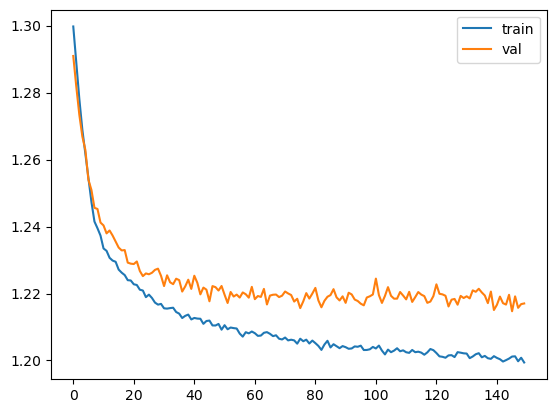

In [12]:
plt.plot(train_losses, label = 'train')
plt.plot(val_losses, label = 'val')
plt.legend()
plt.show()

In [13]:
batch_size = 50
file_path = Path("/kaggle/input/california-spatial-temporal-fire-dataset/numpy_california_spatialtemporal_dataset.npy")
numpy_array = np.load(file_path)[:,:,700:,:]
dataloader = temporal_dataloader(numpy_array, sequence_length, batch_size, radius = 2, train_or_test = False, pin_memory = False, num_workers=0)
f1, recall, precision, auprc, aucroc, accuracy, samples, loss, loss_samples = evaluate_model(ConvTranModel, dataloader, criterion, device)
del numpy_array
del dataloader

print(f'epoch #{epoch}:')
print(f'val_loss: {loss/loss_samples}!')
print(f'f1: {f1/samples}')
print(f'recall: {recall/samples}')
print(f'precision: {precision/samples}')
print(f'auprc: {auprc/samples}')
print(f'aucroc: {aucroc/samples}')
print(f'accuracy: {accuracy/samples}')

evaluating: 100%|██████████| 3706/3706 [00:26<00:00, 137.43it/s]

epoch #149:
val_loss: 0.038296014070510864!
f1: 0.17723688944160398
recall: 0.7387191987954635
precision: 0.10363673216813674
auprc: 0.10465261534454953
aucroc: 0.7793171732568965
accuracy: 0.8178863453147193


simple tran

In [14]:
TranModel = TransformerNet() #take their default vals
optimizer = RAdam(TranModel.parameters(), lr=config['lr'], weight_decay=0)
pos_weight = torch.tensor([4]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
#criterion = nn.CrossEntropyLoss()
#criterion = get_loss_module()
print(sum(p.numel() for p in TranModel.parameters()))

TranModel.to(device)

num_epochs = 50
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    
    batch_size = 50
    file_path = Path('/kaggle/input/california-spatial-temporal-fire-dataset/numpy_california_spatialtemporal_dataset.npy')
    train_numpy_array = np.load(file_path)[:,:,:700,:]
    train_dataloader = temporal_dataloader(train_numpy_array, sequence_length, batch_size, radius = 0, train_or_test = True, pin_memory = True, num_workers=0)
    loss, samples = train(TranModel, train_dataloader, optimizer, criterion, device, epoch)
    del train_numpy_array
    del train_dataloader
    #checkpoint_path = f'/kaggle/output/model_checkpoints/model_checkpoint_epoch_{epoch}.pt'
    #torch.save(ConvTranModel.state_dict(), checkpoint_path)
    train_losses.append(loss.item()/samples)
    
    batch_size = 50
    val_numpy_array = np.load(file_path)[:,:,700:,:]
    val_dataloader = temporal_dataloader(val_numpy_array, sequence_length, batch_size, radius = 0, train_or_test = True, pin_memory = True, num_workers=0)
    f1, recall, precision, auprc, aucroc, accuracy, samples, loss, loss_samples = evaluate_model(TranModel, val_dataloader, criterion, device)
    del val_numpy_array
    del val_dataloader
    
    val_losses.append(loss.item()/loss_samples)
    
    print(f'epoch #{epoch}:')
    print(f'train_loss: {train_losses[epoch]}; val_loss: {val_losses[epoch]}!')
    print(f'f1: {f1/samples}')
    print(f'recall: {recall/samples}')
    print(f'precision: {precision/samples}')
    print(f'auprc: {auprc/samples}')
    print(f'aucroc: {aucroc/samples}')
    print(f'accuracy: {accuracy/samples}')

4374275


evaluating: 100%|██████████| 124/124 [00:01<00:00, 62.47it/s]


epoch #0:
train_loss: 0.025269198278064117; val_loss: 0.02454688669642586!
f1: 0.5469513793767942
recall: 0.8048538311419837
precision: 0.4200505425028224
auprc: 0.40574591709164043
aucroc: 0.6247417891140321
accuracy: 0.564526588845655


evaluating: 100%|██████████| 124/124 [00:02<00:00, 61.44it/s]


epoch #1:
train_loss: 0.02401432587732723; val_loss: 0.023643612397783925!
f1: 0.5818680399619113
recall: 0.798941445731471
precision: 0.4641486223862827
auprc: 0.4406350105747129
aucroc: 0.6711512325342108
accuracy: 0.6284046692607004


evaluating: 100%|██████████| 124/124 [00:02<00:00, 61.11it/s]


epoch #2:
train_loss: 0.0229820513565915; val_loss: 0.02301995954535203!
f1: 0.6203087270791551
recall: 0.7809354090817423
precision: 0.5211144470650997
auprc: 0.48316693939138367
aucroc: 0.7106380745365578
accuracy: 0.68731754784301


evaluating: 100%|██████████| 124/124 [00:02<00:00, 61.14it/s]


epoch #3:
train_loss: 0.022483808286549837; val_loss: 0.02296328494358202!
f1: 0.6205983201246388
recall: 0.803347002115039
precision: 0.5125674177854279
auprc: 0.48058637391457865
aucroc: 0.7103067910096541
accuracy: 0.6787741203178207


evaluating: 100%|██████████| 124/124 [00:02<00:00, 61.85it/s]


epoch #4:
train_loss: 0.022316560163091706; val_loss: 0.023001578067527208!
f1: 0.6178927873931787
recall: 0.7757576119951598
precision: 0.5226906835175283
auprc: 0.482338916609647
aucroc: 0.7086841731137814
accuracy: 0.6869325551232166


evaluating: 100%|██████████| 124/124 [00:02<00:00, 61.86it/s]


epoch #5:
train_loss: 0.022183059762750822; val_loss: 0.022980617166280706!
f1: 0.6164366853650062
recall: 0.7203267310439367
precision: 0.5471910697361823
auprc: 0.49394997615232283
aucroc: 0.7104829149356454
accuracy: 0.7086103453867358


evaluating: 100%|██████████| 124/124 [00:02<00:00, 59.81it/s]


epoch #6:
train_loss: 0.022149023434969783; val_loss: 0.022695171170012768!
f1: 0.6357621901533411
recall: 0.7711357405964075
precision: 0.5487945194561185
auprc: 0.504197670289362
aucroc: 0.7275930414000443
accuracy: 0.7128263337116912


evaluating: 100%|██████████| 124/124 [00:01<00:00, 63.00it/s]


epoch #7:
train_loss: 0.022059154876193452; val_loss: 0.02325637114805625!
f1: 0.5998636906271948
recall: 0.6185230776667423
precision: 0.5972431053591805
auprc: 0.5018748528389557
aucroc: 0.7037350646865577
accuracy: 0.7323281452658884


evaluating: 100%|██████████| 124/124 [00:02<00:00, 61.65it/s]


epoch #8:
train_loss: 0.02199280838304446; val_loss: 0.02285593622426031!
f1: 0.6206393106427477
recall: 0.7538673728247546
precision: 0.5363425996185398
auprc: 0.48983415556475507
aucroc: 0.7133518354608236
accuracy: 0.6998053843658774


evaluating: 100%|██████████| 124/124 [00:01<00:00, 62.82it/s]


epoch #9:
train_loss: 0.02196583608758469; val_loss: 0.02266635836011609!
f1: 0.633054124871523
recall: 0.7854646579175828
precision: 0.5397203695586471
auprc: 0.49773108298252544
aucroc: 0.7247471146602568
accuracy: 0.7029349764877574


evaluating: 100%|██████████| 124/124 [00:02<00:00, 61.29it/s]


epoch #10:
train_loss: 0.021980811032651464; val_loss: 0.022825768021757963!
f1: 0.6233339755133656
recall: 0.7687806681554497
precision: 0.5315824335528285
auprc: 0.4896872214629989
aucroc: 0.7145117628038877
accuracy: 0.6968223086900129


evaluating: 100%|██████████| 124/124 [00:02<00:00, 60.71it/s]


epoch #11:
train_loss: 0.02192509431348709; val_loss: 0.02276980855652499!
f1: 0.6299438219975309
recall: 0.7466098078382817
precision: 0.5537723006104662
auprc: 0.5029905811207896
aucroc: 0.7233798566799708
accuracy: 0.7153284671532847


evaluating: 100%|██████████| 124/124 [00:02<00:00, 61.86it/s]


epoch #12:
train_loss: 0.021831553962542265; val_loss: 0.022838510891806756!
f1: 0.6246888612739209
recall: 0.73065963063621
precision: 0.5560283204786427
auprc: 0.49908630215289196
aucroc: 0.7196365268329897
accuracy: 0.7151426718547341


evaluating: 100%|██████████| 124/124 [00:02<00:00, 61.87it/s]


epoch #13:
train_loss: 0.021789841786348206; val_loss: 0.022692317937907852!
f1: 0.633662596811909
recall: 0.7380073184058433
precision: 0.5644609686312646
auprc: 0.5067089736230193
aucroc: 0.7271709611068504
accuracy: 0.7235732814526589


evaluating: 100%|██████████| 124/124 [00:01<00:00, 62.18it/s]


epoch #14:
train_loss: 0.021704850190414002; val_loss: 0.023529369491591998!
f1: 0.5784643057698673
recall: 0.5599969987941855
precision: 0.6156927705745467
auprc: 0.49911774265542835
aucroc: 0.6941582505287296
accuracy: 0.7392150502757054


evaluating: 100%|██████████| 124/124 [00:02<00:00, 61.74it/s]


epoch #15:
train_loss: 0.021668827879050175; val_loss: 0.023515545440555084!
f1: 0.5826681845660046
recall: 0.5727501151307199
precision: 0.6088824354307473
auprc: 0.49682396524153494
aucroc: 0.6944406707849005
accuracy: 0.7350843060959793


evaluating: 100%|██████████| 124/124 [00:02<00:00, 61.81it/s]


epoch #16:
train_loss: 0.021690233415849; val_loss: 0.02277886069186294!
f1: 0.6278003249621018
recall: 0.6933295129747911
precision: 0.584656617367693
auprc: 0.5131161100088207
aucroc: 0.7229918772231735
accuracy: 0.7332576617480137


evaluating: 100%|██████████| 124/124 [00:02<00:00, 60.73it/s]


epoch #17:
train_loss: 0.021601868782751128; val_loss: 0.02291425069173177!
f1: 0.6240682163657391
recall: 0.6764186884312582
precision: 0.5918741027690503
auprc: 0.5140340831398638
aucroc: 0.7211803043348486
accuracy: 0.7360570687418937


evaluating: 100%|██████████| 124/124 [00:02<00:00, 61.46it/s]


epoch #18:
train_loss: 0.021532413656429755; val_loss: 0.022656372703621513!
f1: 0.6348255058602774
recall: 0.725460661413664
precision: 0.5753902102308862
auprc: 0.514535888276555
aucroc: 0.7290062166743904
accuracy: 0.7295719844357976


evaluating: 100%|██████████| 124/124 [00:01<00:00, 62.64it/s]


epoch #19:
train_loss: 0.021472641727307763; val_loss: 0.023285993362953776!
f1: 0.6047409764077308
recall: 0.5795545560028201
precision: 0.6459716876428518
auprc: 0.5224723808414787
aucroc: 0.7106292963512474
accuracy: 0.7535268363872223


evaluating: 100%|██████████| 124/124 [00:02<00:00, 59.40it/s]


epoch #20:
train_loss: 0.02139734344688002; val_loss: 0.022808372577998278!
f1: 0.6291659956675877
recall: 0.6800892535777625
precision: 0.5976597546527272
auprc: 0.5190895759084784
aucroc: 0.7269620537893184
accuracy: 0.7422546634225466


evaluating: 100%|██████████| 124/124 [00:02<00:00, 61.78it/s]


epoch #21:
train_loss: 0.021354050153152532; val_loss: 0.02289434451231099!
f1: 0.6280317647715543
recall: 0.6295193663551938
precision: 0.6421796614979375
auprc: 0.5328100290816518
aucroc: 0.7262708630582283
accuracy: 0.758067131506405


evaluating: 100%|██████████| 124/124 [00:01<00:00, 62.76it/s]


epoch #22:
train_loss: 0.021302734046037716; val_loss: 0.022980424173651086!
f1: 0.6171763049856068
recall: 0.5916317986511822
precision: 0.6612421823782417
auprc: 0.5324512793159544
aucroc: 0.7198002168600633
accuracy: 0.7629317334198151


evaluating: 100%|██████████| 124/124 [00:01<00:00, 62.65it/s]


epoch #23:
train_loss: 0.021223230617417838; val_loss: 0.02291930251565414!
f1: 0.6213561412873075
recall: 0.6149134184586026
precision: 0.6418434965716555
auprc: 0.5286618609663628
aucroc: 0.7224084808713156
accuracy: 0.7583522542977619


evaluating: 100%|██████████| 124/124 [00:02<00:00, 61.73it/s]


epoch #24:
train_loss: 0.021158634881205306; val_loss: 0.02266350937199032!
f1: 0.6389446072170325
recall: 0.6204353717488522
precision: 0.6757754051334023
auprc: 0.5518005960058567
aucroc: 0.7368148142008855
accuracy: 0.7753446877534469


evaluating: 100%|██████████| 124/124 [00:02<00:00, 61.27it/s]


epoch #25:
train_loss: 0.02111069282291343; val_loss: 0.022363101152749067!
f1: 0.6598950413947537
recall: 0.7134077534336662
precision: 0.625836708937147
auprc: 0.5457450448029976
aucroc: 0.7503638671483864
accuracy: 0.7624837872892347


evaluating: 100%|██████████| 124/124 [00:02<00:00, 61.87it/s]


epoch #26:
train_loss: 0.021074480550623574; val_loss: 0.02263448735931926!
f1: 0.6416982905948326
recall: 0.6241570444629291
precision: 0.6801958049092317
auprc: 0.5565560378758798
aucroc: 0.7406269720816956
accuracy: 0.7783363061456138


evaluating: 100%|██████████| 124/124 [00:02<00:00, 59.84it/s]


epoch #27:
train_loss: 0.02101118807496648; val_loss: 0.022834751852254184!
f1: 0.6349754454735664
recall: 0.6079044246499822
precision: 0.6823647692835905
auprc: 0.5498136410834185
aucroc: 0.7327786544357917
accuracy: 0.77330955083509


evaluating: 100%|██████████| 124/124 [00:02<00:00, 61.10it/s]


epoch #28:
train_loss: 0.021002683042090103; val_loss: 0.022459559334683344!
f1: 0.6541787462402839
recall: 0.6656184840438076
precision: 0.6571237259996366
auprc: 0.5542202982248552
aucroc: 0.7467334742586321
accuracy: 0.7729852440408627


evaluating: 100%|██████████| 124/124 [00:02<00:00, 58.64it/s]


epoch #29:
train_loss: 0.02101180874515033; val_loss: 0.022468072121863854!
f1: 0.6580173070267549
recall: 0.6732111164980414
precision: 0.6541285387279824
auprc: 0.5555328957887854
aucroc: 0.7478887465438095
accuracy: 0.772697795071336


evaluating: 100%|██████████| 124/124 [00:02<00:00, 61.71it/s]


epoch #30:
train_loss: 0.02089216509239947; val_loss: 0.02270979236326858!
f1: 0.6407629570170208
recall: 0.6068585139776242
precision: 0.6964131730989414
auprc: 0.5586360520872585
aucroc: 0.7378106921613438
accuracy: 0.780895231916964


evaluating: 100%|██████████| 124/124 [00:02<00:00, 61.21it/s]


epoch #31:
train_loss: 0.02084485952539609; val_loss: 0.02245553442838225!
f1: 0.6516629942725667
recall: 0.6624587150866997
precision: 0.6558554123046486
auprc: 0.5498976657584034
aucroc: 0.7445973048956868
accuracy: 0.7730738037307381


evaluating: 100%|██████████| 124/124 [00:02<00:00, 60.40it/s]


epoch #32:
train_loss: 0.020932866906964092; val_loss: 0.022352346980399708!
f1: 0.6634346659978221
recall: 0.6647444169445953
precision: 0.6775576307588038
auprc: 0.5652841944395947
aucroc: 0.7520121917013819
accuracy: 0.7814172206907735


evaluating: 100%|██████████| 124/124 [00:02<00:00, 61.20it/s]


epoch #33:
train_loss: 0.02074640562453039; val_loss: 0.0223423726518485!
f1: 0.6572583868219566
recall: 0.6803960274581131
precision: 0.6484648793916232
auprc: 0.5523316036571932
aucroc: 0.7489482656946552
accuracy: 0.7733463035019456


evaluating: 100%|██████████| 124/124 [00:02<00:00, 59.19it/s]


epoch #34:
train_loss: 0.02076756062764371; val_loss: 0.022699228015148596!
f1: 0.6482832388453942
recall: 0.6221230253180803
precision: 0.6934478440930241
auprc: 0.5615579125521832
aucroc: 0.7406227583168068
accuracy: 0.7795977943561466


evaluating: 100%|██████████| 124/124 [00:02<00:00, 59.00it/s]


epoch #35:
train_loss: 0.020729151526751245; val_loss: 0.022393559775412797!
f1: 0.6621227672968545
recall: 0.6578960074935651
precision: 0.6802379474852966
auprc: 0.5648846296213289
aucroc: 0.751489340760196
accuracy: 0.7838144664288031


evaluating: 100%|██████████| 124/124 [00:02<00:00, 60.03it/s]


epoch #36:
train_loss: 0.02064962110822359; val_loss: 0.02237713537945976!
f1: 0.6682340452366675
recall: 0.6633686439821846
precision: 0.68709192732173
auprc: 0.5740248048896738
aucroc: 0.7556804284585447
accuracy: 0.7855058365758755


evaluating: 100%|██████████| 124/124 [00:02<00:00, 56.53it/s]


epoch #37:
train_loss: 0.020679345171696846; val_loss: 0.022446832092235657!
f1: 0.6563105363333201
recall: 0.6516111669996084
precision: 0.677132505272564
auprc: 0.5619140246041087
aucroc: 0.7480834478722487
accuracy: 0.781184103811841


evaluating: 100%|██████████| 124/124 [00:02<00:00, 60.33it/s]


epoch #38:
train_loss: 0.020625178190522495; val_loss: 0.02228080857142224!
f1: 0.6604802272144458
recall: 0.7215291026715247
precision: 0.6212948605201736
auprc: 0.5459180895093872
aucroc: 0.7519230243842338
accuracy: 0.7619588130371331


evaluating: 100%|██████████| 124/124 [00:02<00:00, 60.13it/s]


epoch #39:
train_loss: 0.02064567136571795; val_loss: 0.02231626597205334!
f1: 0.6586023759039098
recall: 0.7175692511393339
precision: 0.6175789172233105
auprc: 0.5425518613623759
aucroc: 0.7478908205128108
accuracy: 0.7594033722438391


evaluating: 100%|██████████| 124/124 [00:02<00:00, 60.36it/s]


epoch #40:
train_loss: 0.020568267287757312; val_loss: 0.022382673720744303!
f1: 0.6594465574129311
recall: 0.6717519536204143
precision: 0.6595935099004783
auprc: 0.5575219743609184
aucroc: 0.7491449925568769
accuracy: 0.775218942588388


evaluating: 100%|██████████| 124/124 [00:02<00:00, 59.13it/s]


epoch #41:
train_loss: 0.020557756249979756; val_loss: 0.022555917090683022!
f1: 0.651151429709843
recall: 0.6144961259299924
precision: 0.7100023134100198
auprc: 0.5708900368629245
aucroc: 0.7459538333715614
accuracy: 0.7896870439435706


evaluating: 100%|██████████| 124/124 [00:02<00:00, 61.24it/s]


epoch #42:
train_loss: 0.020647395075955085; val_loss: 0.02265252227313093!
f1: 0.6476074041881278
recall: 0.6307337777001951
precision: 0.6802434666754257
auprc: 0.5578883416875207
aucroc: 0.741001828255324
accuracy: 0.7768769255715907


evaluating: 100%|██████████| 124/124 [00:02<00:00, 60.05it/s]


epoch #43:
train_loss: 0.020487996712369474; val_loss: 0.022557649075820647!
f1: 0.652970186591604
recall: 0.6438636385116927
precision: 0.6752868029403979
auprc: 0.5576207466098398
aucroc: 0.7442672500626508
accuracy: 0.7781741527485001


evaluating: 100%|██████████| 124/124 [00:02<00:00, 60.47it/s]


epoch #44:
train_loss: 0.020488590173470777; val_loss: 0.022448435488591673!
f1: 0.6549808298313693
recall: 0.6658109541252671
precision: 0.6550279414345489
auprc: 0.5525473495414526
aucroc: 0.7452115474942167
accuracy: 0.7737593253324684


evaluating: 100%|██████████| 124/124 [00:02<00:00, 61.40it/s]


epoch #45:
train_loss: 0.020533270963629384; val_loss: 0.022384467910390574!
f1: 0.656924715592625
recall: 0.7332413858391147
precision: 0.6022215116763185
auprc: 0.5360097101386561
aucroc: 0.7458467330967287
accuracy: 0.7506485084306096


evaluating: 100%|██████████| 124/124 [00:02<00:00, 60.45it/s]


epoch #46:
train_loss: 0.020507437711627337; val_loss: 0.022601499563683788!
f1: 0.6438854278002396
recall: 0.649118821178943
precision: 0.6525219815870329
auprc: 0.5468383602380461
aucroc: 0.7383323365118157
accuracy: 0.7680077871512005


evaluating: 100%|██████████| 124/124 [00:02<00:00, 61.39it/s]


epoch #47:
train_loss: 0.02045112683013734; val_loss: 0.022363477738461167!
f1: 0.6584969538354548
recall: 0.6921883769137046
precision: 0.6411378860429781
auprc: 0.5526862571265192
aucroc: 0.7500233969185133
accuracy: 0.7690561141745054


evaluating: 100%|██████████| 124/124 [00:02<00:00, 61.06it/s]


epoch #48:
train_loss: 0.02039161703477611; val_loss: 0.02241570043501996!
f1: 0.6626348317761941
recall: 0.6541182098387491
precision: 0.6847564922833433
auprc: 0.5682900262844508
aucroc: 0.7511183563970741
accuracy: 0.7829118028534371


evaluating: 100%|██████████| 124/124 [00:02<00:00, 60.66it/s]


epoch #49:
train_loss: 0.02035683937136016; val_loss: 0.0226452751524622!
f1: 0.6480537267748315
recall: 0.6244875422725671
precision: 0.686432930713388
auprc: 0.5570039180289447
aucroc: 0.7407062390087721
accuracy: 0.779633533322523


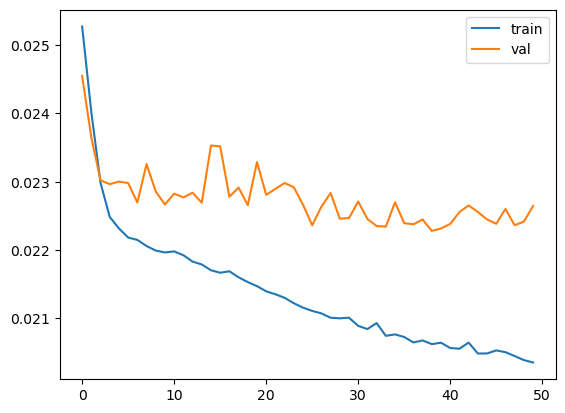

In [15]:
plt.plot(train_losses, label = 'train')
plt.plot(val_losses, label = 'val')
plt.legend()
plt.show()

In [16]:
batch_size = 50
file_path = Path("/kaggle/input/california-spatial-temporal-fire-dataset/numpy_california_spatialtemporal_dataset.npy")
numpy_array = np.load(file_path)[:,:,700:,:]
dataloader = temporal_dataloader(numpy_array, sequence_length, batch_size, radius = 2, train_or_test = False, pin_memory = False, num_workers=0)
f1, recall, precision, auprc, aucroc, accuracy, samples, loss, loss_samples = evaluate_model(TranModel, dataloader, criterion, device)
del numpy_array
del dataloader

print(f'epoch #{epoch}:')
print(f'val_loss: {loss/loss_samples}!')
print(f'f1: {f1/samples}')
print(f'recall: {recall/samples}')
print(f'precision: {precision/samples}')
print(f'auprc: {auprc/samples}')
print(f'aucroc: {aucroc/samples}')
print(f'accuracy: {accuracy/samples}')

evaluating:  22%|██▏       | 813/3706 [00:08<00:30, 94.85it/s]/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
evaluating: 100%|██████████| 3706/3706 [00:40<00:00, 92.03it/s]

epoch #49:
val_loss: 0.015876006335020065!
f1: 0.18002994557376684
recall: 0.6261413601893565
precision: 0.10949526601708179
auprc: 0.10993393047370174
aucroc: 0.7417939505265029
accuracy: 0.8514557412237461
